# Feature-based analysis 

This is one of the key analysis to compare different experimental conditions and to guide future insights and reports. After analyzing the raw data and obtaining a summarized metric set, we can consider each measurement as a feature in a dataset and understand which of these statistical features and measurements is most informative and better differentiates the different experimental conditions (*feature importance* analysis) or we can use this dataset to train machine learning models to predict experimental conditions (*classification* analysis) or to obtain a suitable visualization of the data structure (*geometric* analysis).

These analysis start with loading a pre-computed DataFrame with all the metrics computed for all experimental conditions. This can be obtained with the tools provided in MEA-flow (see examples in [activity_analysis.ipynb](activity_analysis.ipynb)) or any external tools that pre-processed and analyzed the dataset. When considered like this, we have a dataset with `n_samples` (unique observations or measurements) and `n_features` (set of metrics).

The most critical aspect (from a machine learning standpoint) is that it is not advisable to have a single measurement per condition. We consider a measurement as a `sample` in our dataset so we need to have multiple measurements/samples per condition (either multiple recordings, multiple wells, or multiple time windows). Consider, for example, that we use the entire metric set available in MEA-flow, comprising 70+ features (comprising metrics of activity, regularity, synchrony, burstiness, etc.). If we only have one measurement per condition (e.g. mean firing rate for condition 1), this dataset suffers from the **curse of dimensionality** (`n_samples` << `n_features`) and is not informative enough to perform a proper analysis. Many of the ML algorithms will fail in these circumstances and those that don't will provide very unstable results. 

In [activity_analysis.ipynb](activity_analysis.ipynb), we demonstrate how we can augment our dataset to mitigate this effect by performing different groupings of the data:
1. Grouping only by condition → 1 sample per feature per condition ❌ 
2. Grouping by condition and well → 1 sample per feature per condition per well (4x samples per condition) ⚠️
3. Grouping by condition and time → 1 sample per feature per condition per time window (n_time_windows samples per condition) ✅
4. Grouping by condition and single electrode → 1 sample per feature per condition per electrode (n_electrodes samples per condition) ✅

---


In [1]:
import pandas as pd

# load DataFrame
results_global = pd.read_csv('results_global.csv', index_col=0)
results_wells = pd.read_csv('results_wells.csv', index_col=0)
results_temporal = pd.read_csv('results_temporal.csv', index_col=0)
results_channels = pd.read_csv('results_channels.csv', index_col=0)

## 1. Exploratory analysis - visualizing the structure of the data

A good way to start analyzing the data is to visualize its structure. This can help identify patterns, clusters, and relationships between variables. As mentioned above, having a single datapoint per condition is not ideal for visualization methods. So, we will ignore the `global` dataset and use the `temporal` one instead, where each metric was applied to each time window separately, yielding a richer dataset.

### 1.1. Dimensionality reduction and manifold learning

The first class of methods attempts to reduce the dimensionality of the data while preserving its structure. This can help visualize the data and identify patterns. A complete explanation of the methods implemented in MEA-flow is provided in [MANIFOLD_METHODS_DOCUMENTATION.md](MANIFOLD_METHODS_DOCUMENTATION.md).

In [9]:
import matplotlib.pyplot as plt
from mea_flow.analysis import analyze_feature_space


=== Feature Space Manifold Analysis ===
Data shape: (180, 47) (180 samples, 50 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying PCA...
Applying MDS...


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [40 41 42]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Applying TSNE...
Applying SPECTRAL...
Applying UMAP...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Analysis Summary ===
Number of features: 50
Number of samples: 180
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']

PCA:
  Total explained variance: 66.1%

MDS:
  Stress: 48915.3111

TSNE:
  KL divergence: 0.2198

SPECTRAL:

UMAP:


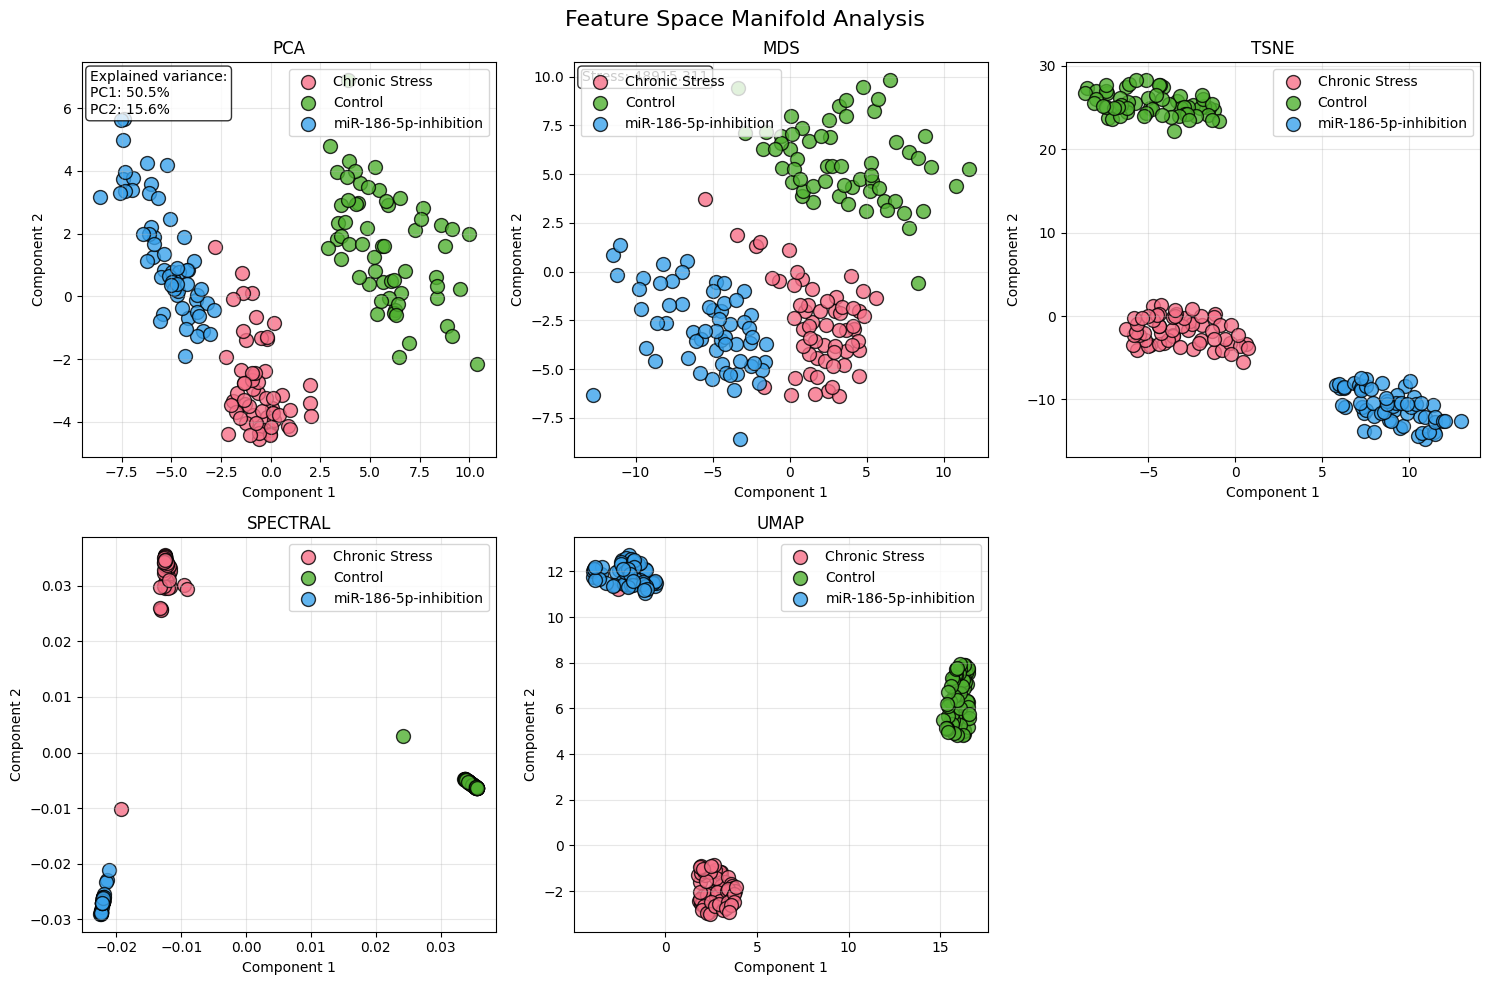

In [10]:
# Simple one-line analysis
results = analyze_feature_space(
    csv_path='./testing/results_temporal.csv',
    condition_column='condition',  # Replace with your actual condition column
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length'],  # Non-measurement columns to exclude
    methods=['PCA', 'MDS', 'TSNE', 'SPECTRAL', 'UMAP'],
    condition_names={'control': 'Control', 'chronic-stress': 'Chronic Stress', 'miR-186-5p-inhibition': 'miR-186-5p-inhibition'}  # Optional
)

Or, we can do a more fine-grained analysis, instead of using the wrapper above, so we have control over each step of the process. Let's demonstrate this with the single unit dataset.

/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying PCA...
Applying MDS...
Applying TSNE...
Applying SPECTRAL...
Applying UMAP...


/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


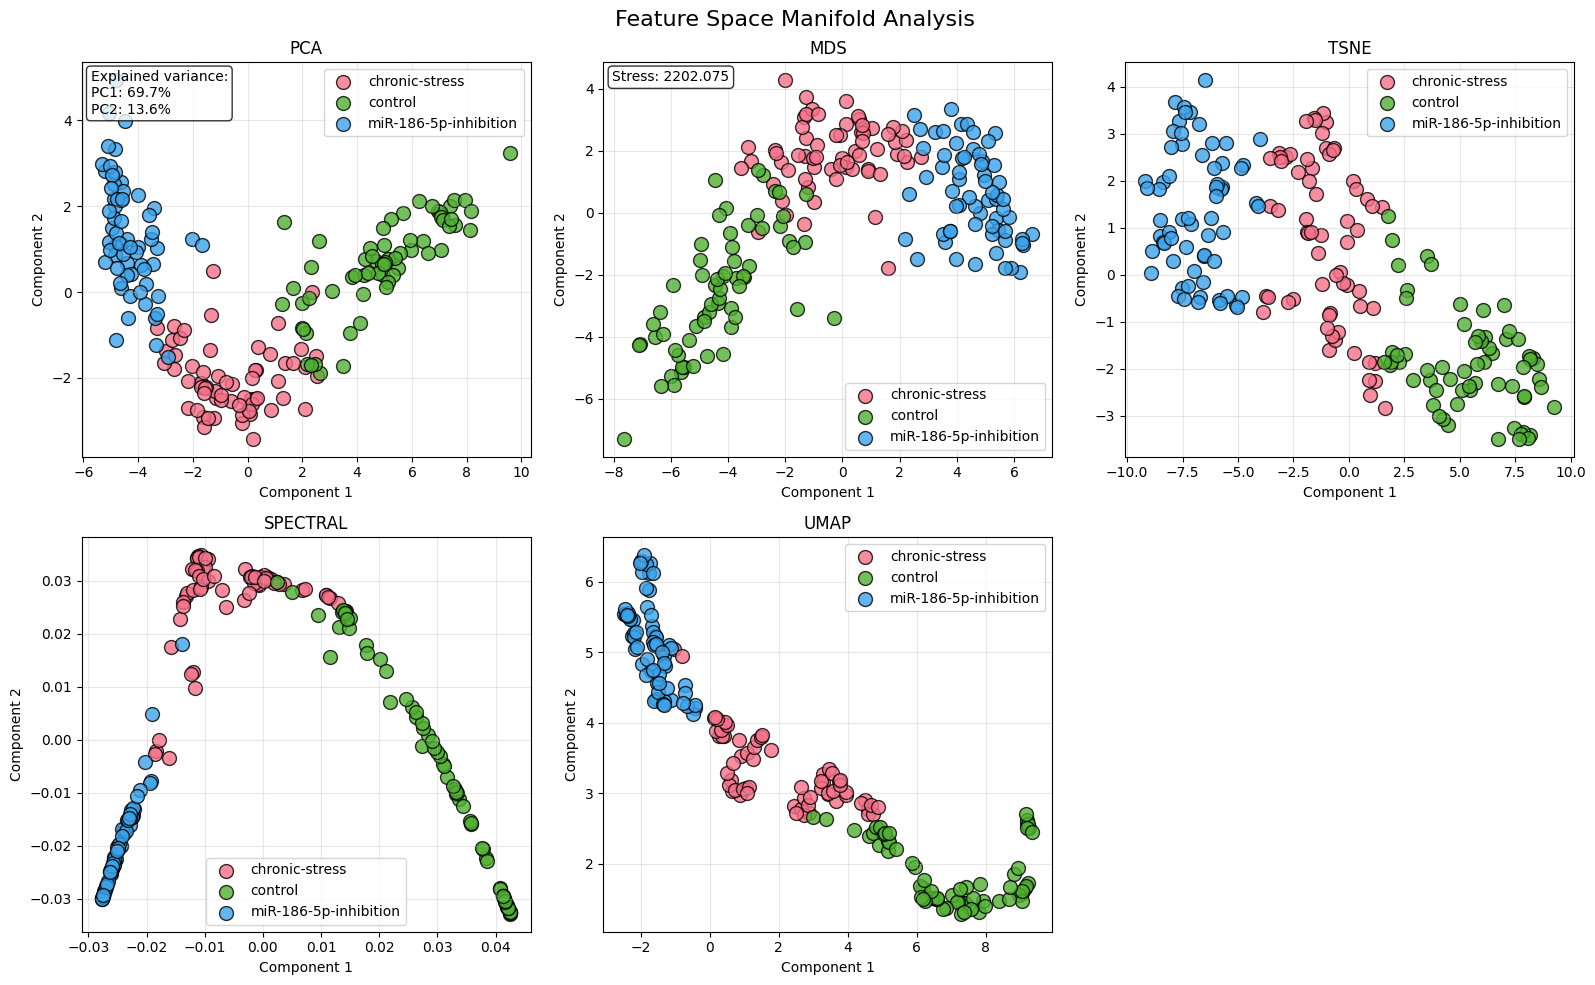

In [12]:
from mea_flow.analysis import (
    load_feature_data, 
    apply_multiple_embeddings, 
    plot_feature_embeddings,
)
import matplotlib.pyplot as plt

# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# Step 2: Apply embedding methods
embeddings, scaler = apply_multiple_embeddings(
    X, 
    methods=['PCA', 'MDS', 'TSNE', 'SPECTRAL', 'UMAP'],
    n_components=3
)

# Step 3: Create visualization
fig = plot_feature_embeddings(
    embeddings, 
    labels,
    # condition_names={0: 'Control', 1: 'Drug A', 2: 'Drug B'},
    figsize=(16, 10)
)
plt.show()

We can already see that different ways of analyzing and grouping the data give rise to very different structure. In any case, this is just the beginning of the analysis pipeline and serves as an indication of what we can expect from it. We can complement this initial, exploratory analysis with clustering algorithms to explore natural groupings in the data and to consolidate different features and measurements.

### 1.2. Cluster analysis
Whereas the previous methods, dimensionality reduction methods (PCA, MDS, t-SNE, UMAP, Spectral Embedding), are primarily unsupervised learning techniques focused on preserving data structure in lower dimensions, clustering algorithms attempt to group similar data points together and find commonalities and community structure in the datasets.  
A detailed explanation of all clustering methods implemented in MEA-Flow can be found in the [CLUSTERING_METHODS_DOCUMENTATION.md](CLUSTERING_METHODS_DOCUMENTATION.md). We will now demonstrate their application to the temporal dataset. We devised 3 ways to apply clustering algorithms to the data: a simple one-liner (`analyze_clustering`), a more complex step-by-step approach that allows us to select and parameterize methods more carefully, and an individualized application of each method, in case one needs to tweak parameters or combine different methods.

The clustering algorithms implemented are: 
- `K-means`: Fast, spherical clusters
- `GMM`: Probabilistic, flexible shapes
- `DBSCAN`: Density-based, automatic cluster detection
- `Hierarchical`: Tree structure, dendrograms

=== Feature Space Clustering Analysis ===
Data shape: (180, 47) (180 samples, 50 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying KMEANS...
Applying GMM...


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [40 41 42]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Applying DBSCAN...
Applying HIERARCHICAL...

=== Clustering Analysis Summary ===
Number of features: 50
Number of samples: 180
True conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Target clusters: 3

=== Method Comparison ===
 n_clusters     inertia  n_iter  silhouette_score  calinski_harabasz_score  davies_bouldin_score       method  adjusted_rand_score  normalized_mutual_info           aic          bic  log_likelihood converged  n_noise_points  noise_ratio  n_leaves  n_connected_components
          3 3537.156237     4.0          0.328559               114.162804              1.180826       KMEANS             0.983286                0.974238           NaN          NaN             NaN       NaN             NaN          NaN       NaN                     NaN
          3         NaN     NaN          0.328559               114.162804              1.180826          GMM             0.983286                0.974238 -19445.944797 -8184.385984       73.610958      True        

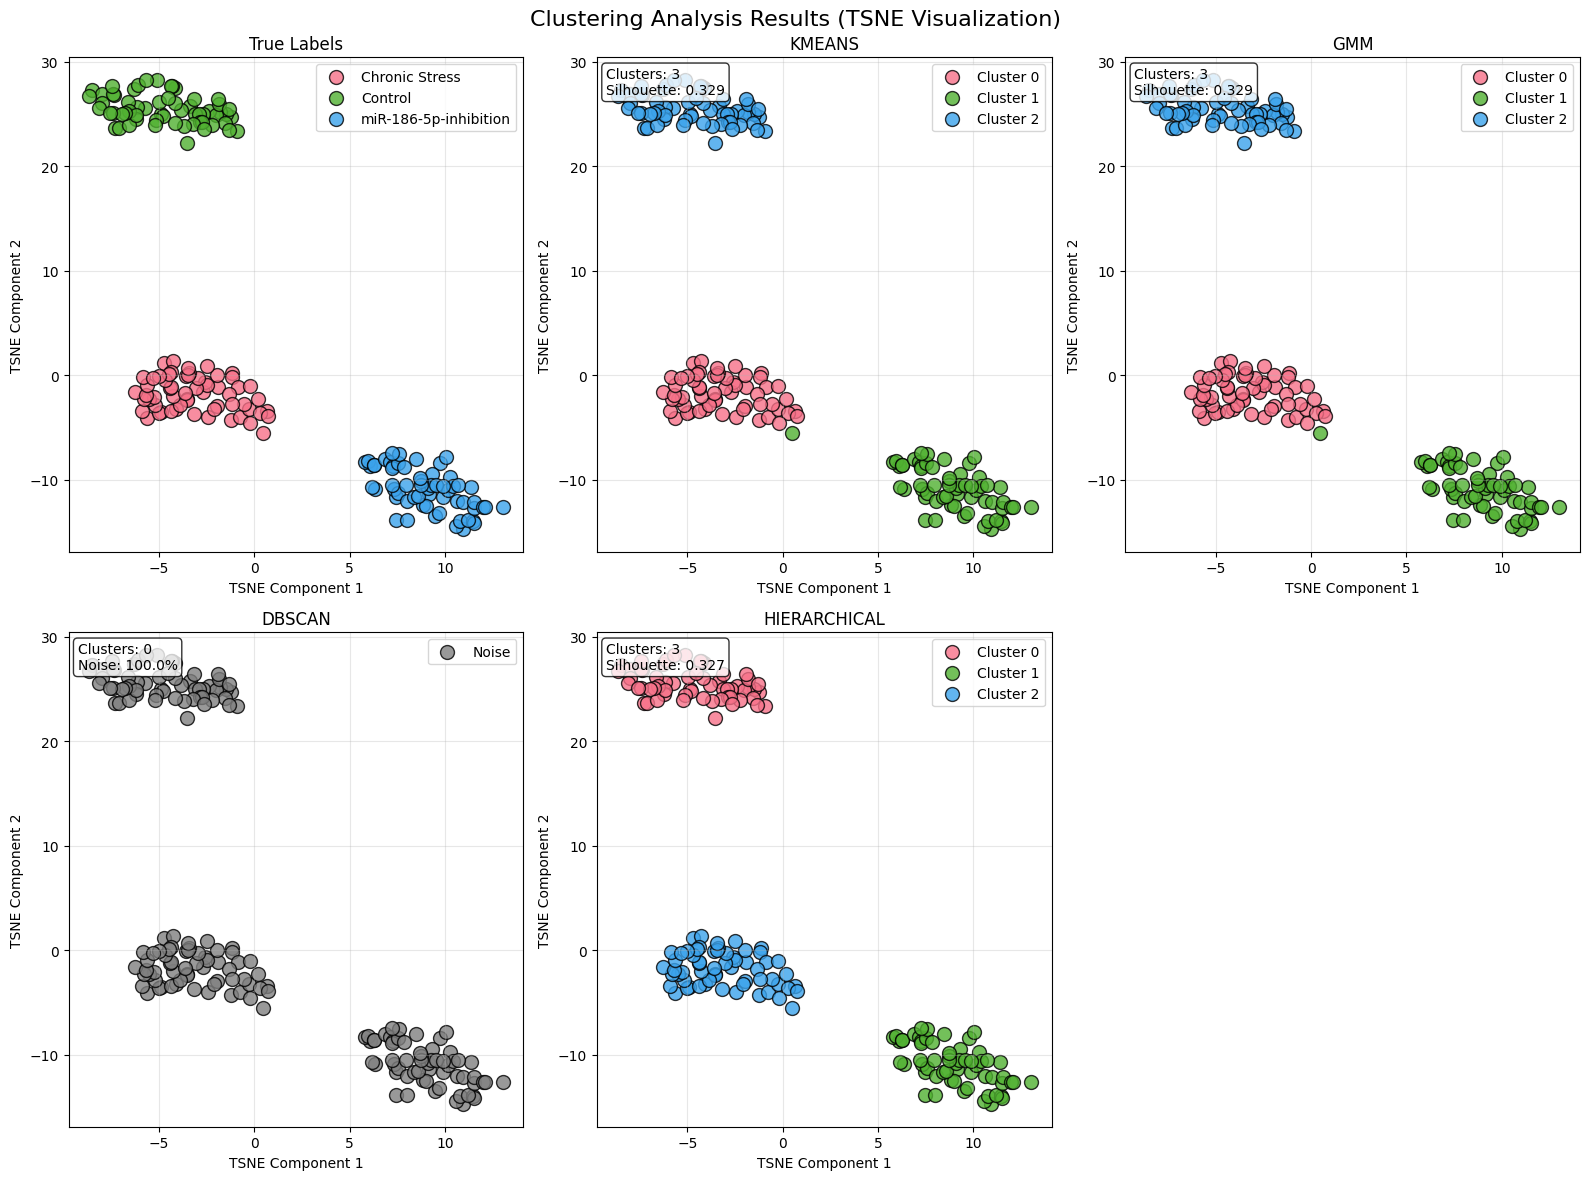

In [2]:
# Simple one-line clustering analysis
from mea_flow.analysis import analyze_clustering

results = analyze_clustering(
    csv_path='./testing/results_temporal.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length'],
    methods=['KMEANS', 'GMM', 'DBSCAN', 'HIERARCHICAL'],
    n_clusters=3,
    embedding_method='TSNE',  # For visualization
    condition_names={'control': 'Control', 'chronic-stress': 'Chronic Stress', 'miR-186-5p-inhibition': 'miR-186-5p-inhibition'}
)

/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
Applying KMEANS...
Applying GMM...
Applying DBSCAN...
Applying HIERARCHICAL...


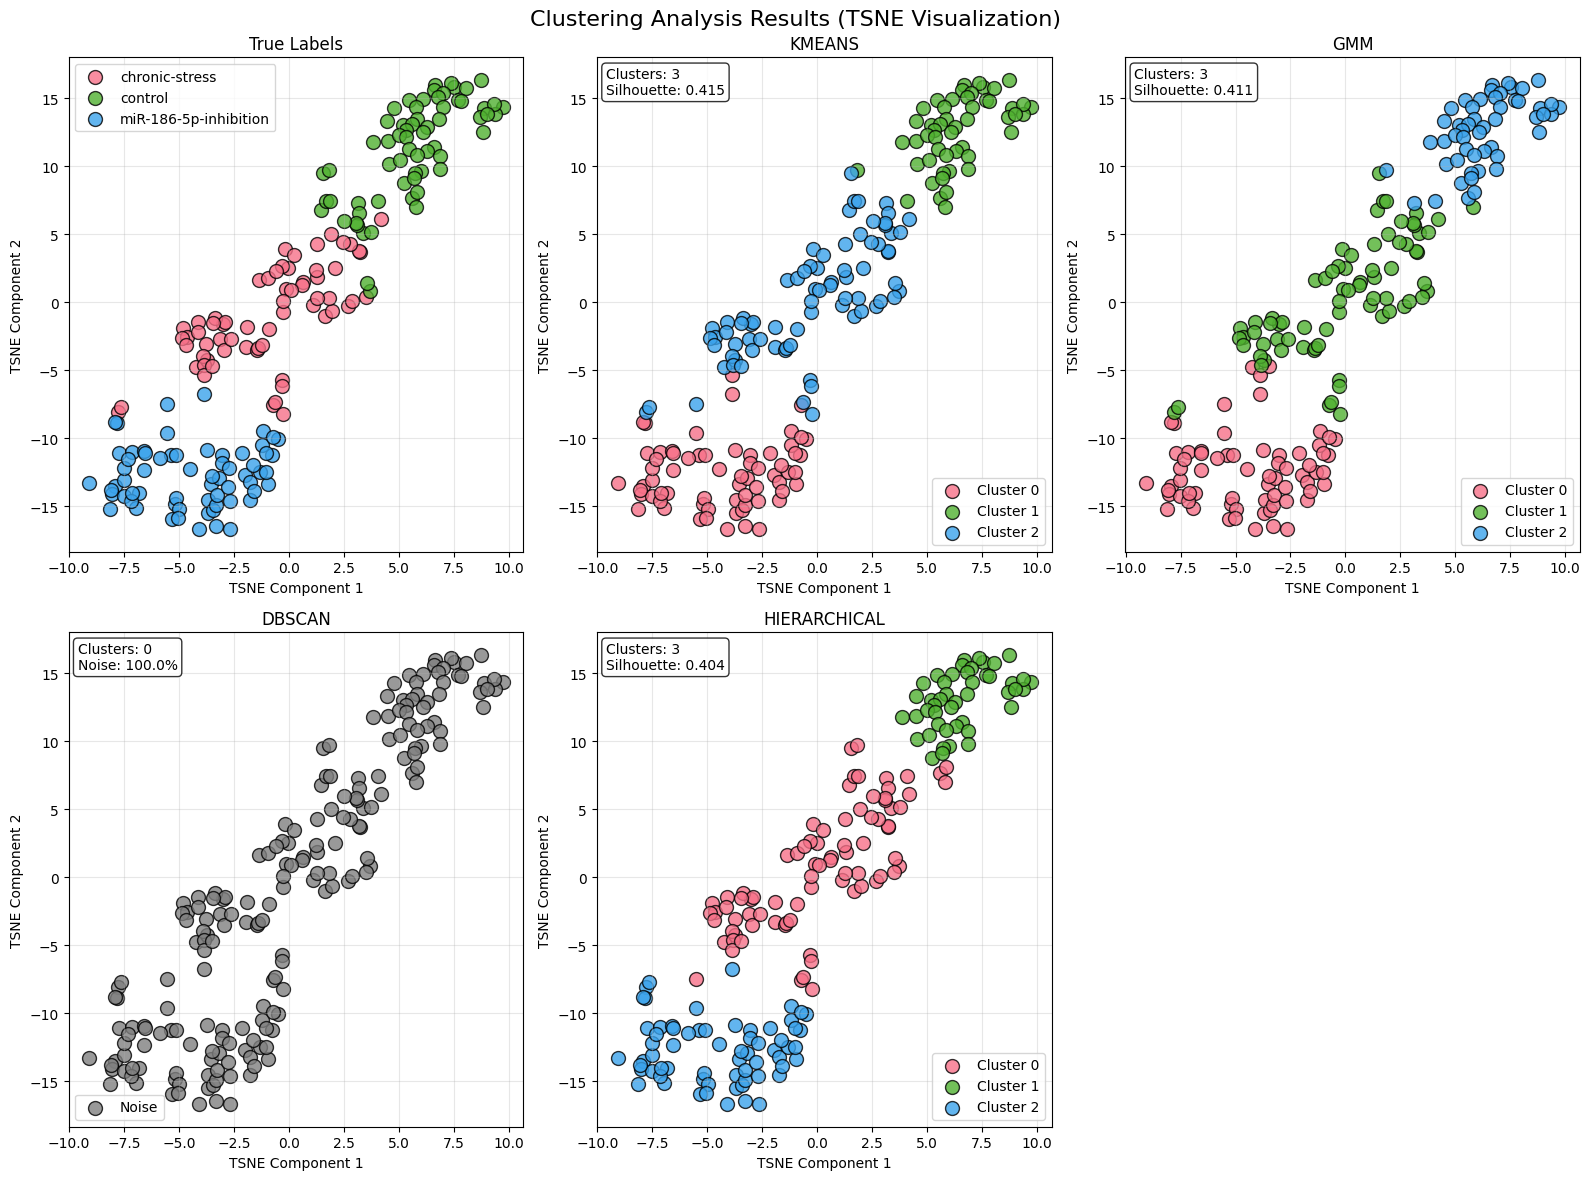

,n_clusters,inertia,n_iter,silhouette_score,calinski_harabasz_score,davies_bouldin_score,adjusted_rand_score,normalized_mutual_info,aic,bic,log_likelihood,converged,n_noise_points,noise_ratio,n_leaves,n_connected_components
method,,,,,,,,,,,,,,,,
KMEANS,3,1336.955688,4.0,0.415428,231.207130,0.912363,0.772417,0.773016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GMM,3,NaN,NaN,0.410935,229.226790,0.918527,0.775435,0.783017,-49214.831857,-42348.031613,139.142791,True,NaN,NaN,NaN,NaN
DBSCAN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,1.0,NaN,NaN
HIERARCHICAL,3,NaN,NaN,0.403648,219.720304,0.918743,0.715371,0.738475,NaN,NaN,NaN,NaN,NaN,NaN,192.0,1.0


In [8]:
from mea_flow.analysis import (
    load_feature_data, 
    apply_multiple_clustering, 
    plot_clustering_results,
    compare_clustering_methods
)
import matplotlib.pyplot as plt

# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# Step 2: Apply clustering methods
clustering_results = apply_multiple_clustering(
    X, 
    methods=['KMEANS', 'GMM', 'DBSCAN', 'HIERARCHICAL'],
    n_clusters=3,
    # Method-specific parameters
    dbscan_eps=0.5,
    dbscan_min_samples=5,
    gmm_covariance_type='full',
    hierarchical_linkage='ward'
)

# Step 3: Create visualization
fig = plot_clustering_results(
    clustering_results, 
    X, 
    labels,
    embedding_method='TSNE',  # Can use PCA, TSNE, UMAP, etc.
    figsize=(16, 12)
)
plt.show()

# Step 4: Compare methods quantitatively
comparison_df = compare_clustering_methods(clustering_results, true_labels=labels)
comparison_df.set_index('method', inplace=True)

comparison_df


/home/neuro/repos/mea-flow/src/mea_flow/analysis/feature_space.py:86: UserWarning: Found NaN values. Filling with column means.
  warnings.warn("Found NaN values. Filling with column means.")
/home/neuro/repos/mea-flow/.venv/lib/python3.10/site-packages/sklearn/impute/_base.py:637: UserWarning: Skipping features without any observed values: [34 35 36 37 38]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data shape: (192, 36) (192 samples, 41 features)
Conditions: ['chronic-stress' 'control' 'miR-186-5p-inhibition']
BIC: -42348.03
Found 0 clusters
Noise ratio: 100.0%


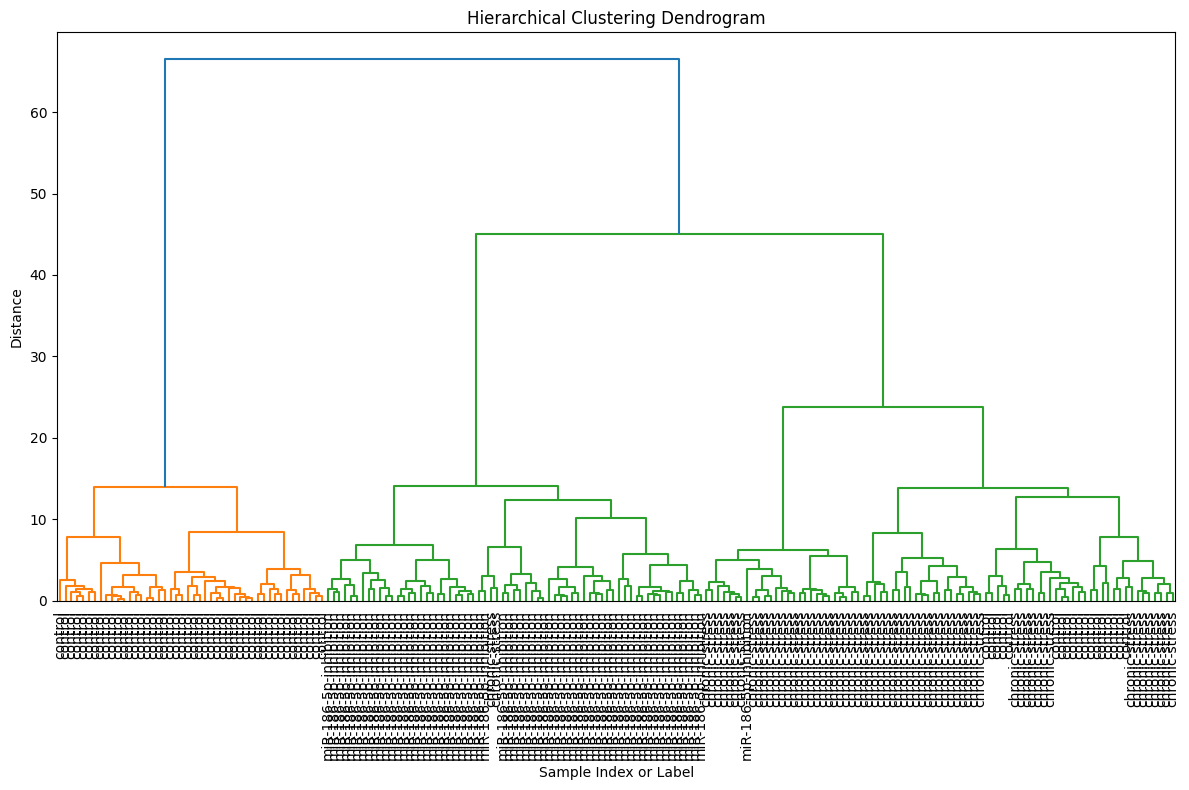

In [ ]:
# Apply manually
from mea_flow.analysis import (
    apply_kmeans_clustering,
    apply_gmm_clustering, 
    apply_dbscan_clustering,
    apply_hierarchical_clustering,
    plot_dendrogram
)
# Step 1: Load data
X, labels, feature_names = load_feature_data(
    csv_path='testing/results_channels.csv',
    condition_column='condition',
    exclude_columns=['group_type', 'group_id', 'n_channels', 'recording_length']
)

# K-means clustering
kmeans_result = apply_kmeans_clustering(X, n_clusters=3, random_state=42)

# GMM with model selection
gmm_result = apply_gmm_clustering(X, n_components=3, covariance_type='full')
print(f"BIC: {gmm_result['metrics']['bic']:.2f}")

# DBSCAN for automatic cluster detection
dbscan_result = apply_dbscan_clustering(X, eps=0.5, min_samples=5)
print(f"Found {dbscan_result['metrics']['n_clusters']} clusters")
print(f"Noise ratio: {dbscan_result['metrics']['noise_ratio']:.1%}")

# Hierarchical clustering with dendrogram
hierarchical_result = apply_hierarchical_clustering(X, n_clusters=3, linkage_method='ward')
dendrogram_fig = plot_dendrogram(hierarchical_result, labels=labels)
plt.show()

---

## 2. Feature importance 
The goal of these analysis is to determine which, among the many measurements/features allows a clearer differentiation between experimental conditions, thus indicating the most prevalent effects of the experimental manipulation. Understanding the significance of the different metrics/features and their impact in the data structure is very important not only in biological terms (to identify causality: experimental modification x yields effect y) but also to identify redundancies and irrelevant measurements that do not contribute meaningful information. 
An appropriate feature analysis requires a comprehensive pipeline to move from raw metric space to informative feature spaces that identify the conditions of interest and their main effects. This pipeline involves (see [FEATURE_ANALYSIS_METHODS_REFERENCE.md](FEATURE_ANALYSIS_METHODS_REFERENCE.md) for a complete description of all methods involved):

1. Preprocessing and redundancy detection
2. Core feature selection and ranking
3. Validation and consensus
4. Feature categorization and final ranking



In [2]:
from mea_flow.analysis import get_available_methods

# Get list of all available methods
available_methods = get_available_methods()
print(available_methods)

/home/neuro/repos/mea-flow/src/mea_flow/analysis/synchrony.py:19: UserWarning: PySpike not available. Some synchrony metrics will be disabled.
  warnings.warn("PySpike not available. Some synchrony metrics will be disabled.")
/home/neuro/repos/mea-flow/src/mea_flow/manifold/embedding.py:26: UserWarning: UMAP not available. UMAP embedding will be disabled.
  warnings.warn("UMAP not available. UMAP embedding will be disabled.")


['RF', 'RANDOM_FOREST', 'LDA', 'LINEAR_DISCRIMINANT', 'SVM', 'LR', 'LOGISTIC', 'LOGISTIC_REGRESSION']


### Implemented Methods

1. **Random Forest (`"RF"`)**
Builds multiple decision trees and combines their votes. Uses feature importance based on how much each feature reduces impurity across all trees. Handles non-linear relationships and mixed data types robustly without overfitting.

2. **Linear Discriminant Analysis (`"LDA"`)**
Projects data to maximize class separation assuming linear boundaries and normal distributions. Feature importance comes from linear coefficients. Fast and interpretable but limited to linear relationships.

3. **Support Vector Machine (`"SVM"`)**
Finds optimal separating hyperplane using support vectors. Can handle non-linear boundaries with kernels. Feature importance available for linear kernels only. Works well with high-dimensional data.

4. **Logistic Regression (`"LR"`)**
Uses linear combination of features with sigmoid function to output probabilities. Feature importance from coefficient magnitudes. Fast and interpretable but limited to linear relationships.

---

#### **Recommendations for MEA Data:**
- **Start with Random Forest** - Most robust for complex neural data with non-linear relationships
- **Use LDA** - When you expect linear relationships between neural metrics and conditions
- **Try SVM** - For high-dimensional datasets (many electrodes/features) with clear class separation
- **Use Logistic Regression** - When you need probability estimates and suspect linear relationships

Begin with Random Forest for baseline results, then compare with LDA if interpretability is crucial. The compare_discriminant_methods() function lets you easily test multiple approaches and see which works best for your specific sdataset.

### Selecting the best method 

We will first analyze the richest dataset, where the analysis was done on multiple time windows, providing a substantial number of samples per feature. Let's compare how the different methods perform.

In [3]:
data = pd.read_csv('results_temporal.csv', index_col=0)
data

,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,active_channels_count,...,van_rossum_distance_std,chi_square_distance,population_spike_synchrony,synchrony_index,group_type,group_id,window_start,window_end,n_channels,recording_length
0,control,118.578125,73.364664,132.2,245.8,5.6,37945,592.890625,366.823319,64,...,122.685853,23.138120,0.339217,1.000,time,0,0.0,5.0,64,5.0
1,control,90.506250,56.154318,80.4,206.8,4.6,28962,452.531250,280.771591,64,...,117.723255,15.698743,0.272810,1.000,time,1,5.0,10.0,64,5.0
2,control,66.931250,44.010527,63.2,173.0,2.2,21418,334.656250,220.052637,64,...,111.959572,9.441962,0.216754,1.000,time,2,10.0,15.0,64,5.0
3,control,115.228571,76.108034,116.6,296.2,5.0,36297,576.142857,380.540170,63,...,144.012618,25.085127,0.300691,1.000,time,3,15.0,20.0,64,5.0
4,control,74.162500,50.038471,76.6,200.4,7.0,23732,370.812500,250.192356,64,...,108.492304,10.736002,0.236094,1.000,time,4,20.0,25.0,64,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,miR-186-5p-inhibition,8.629167,3.825570,8.0,17.4,2.6,2071,43.145833,19.127848,48,...,30.666677,5.546286,0.129847,0.344,time,55,275.0,280.0,58,5.0
176,miR-186-5p-inhibition,11.200000,8.325925,9.6,34.2,2.0,2184,56.000000,41.629625,39,...,43.706547,4.769777,0.122925,0.404,time,56,280.0,285.0,54,5.0
177,miR-186-5p-inhibition,14.264706,7.327903,12.9,37.4,2.8,2425,71.323529,36.639516,34,...,46.619028,5.252062,0.185287,0.374,time,57,285.0,290.0,44,5.0
178,miR-186-5p-inhibition,14.306122,7.936699,14.0,39.2,2.6,3505,71.530612,39.683494,49,...,46.866418,5.503381,0.137288,0.500,time,58,290.0,295.0,59,5.0


In [4]:
from mea_flow.analysis import (
    compare_discriminant_methods, 
    DiscriminantConfig, 
    get_available_methods
)
from mea_flow.visualization import (
    plot_method_comparison,
    plot_feature_importance_comparison
)

# Create base configuration
base_config = DiscriminantConfig(
    target_column="condition",
    exclude_columns=list(data.columns)[-6:],  # Non-feature columns
    scale_features=True,
    cross_validation=True,
    cv_folds=5
)

# Compare all methods
method_results = compare_discriminant_methods(
    data=data,
    base_config=base_config,
    methods=None  # Uses all available methods
)

# View results
for method_name, result in method_results.items():
    print(f"\n{method_name.upper()}:")
    print(f"  CV Accuracy: {result.model_performance['cv_mean_accuracy']:.3f} ± {result.model_performance['cv_std_accuracy']:.3f}")
    print(f"  Train Accuracy: {result.model_performance['train_accuracy']:.3f}")
    print(f"  Top 3 Features:")
    for i, row in result.feature_importance.head(3).iterrows():
        print(f"    {row['feature']}: {row['importance']:.3f}")


/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")



RANDOM_FOREST:
  CV Accuracy: 0.994 ± 0.011
  Train Accuracy: 1.000
  Top 3 Features:
    participation_ratio_mean: 0.087
    cv_isi_mean: 0.082
    cv_isi_std: 0.072

LINEAR_DISCRIMINANT:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    population_cv: 0.224
    global_activity_cv: 0.219
    entropy_isi_mean: 0.078

SVM:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    mean_firing_rate: 0.023
    std_firing_rate: 0.023
    median_firing_rate: 0.023

LOGISTIC_REGRESSION:
  CV Accuracy: 0.994 ± 0.011
  Train Accuracy: 1.000
  Top 3 Features:
    entropy_isi_std: 0.059
    participation_ratio_mean: 0.052
    lv_isi_median: 0.043


/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust im

/tmp/ipykernel_93976/3342975506.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()



Best method: linear_discriminant with 1.000 accuracy


/tmp/ipykernel_93976/3342975506.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


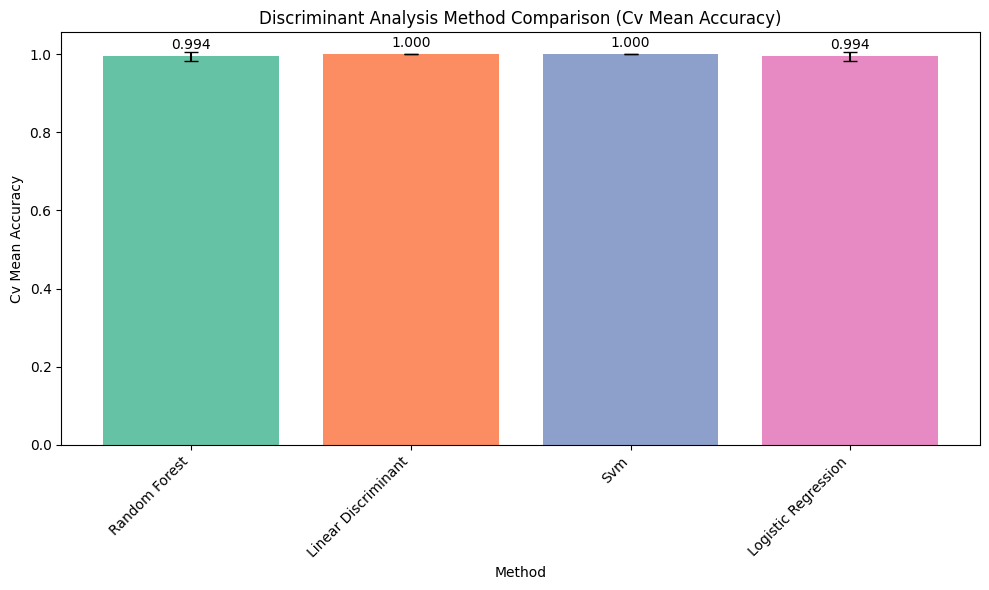

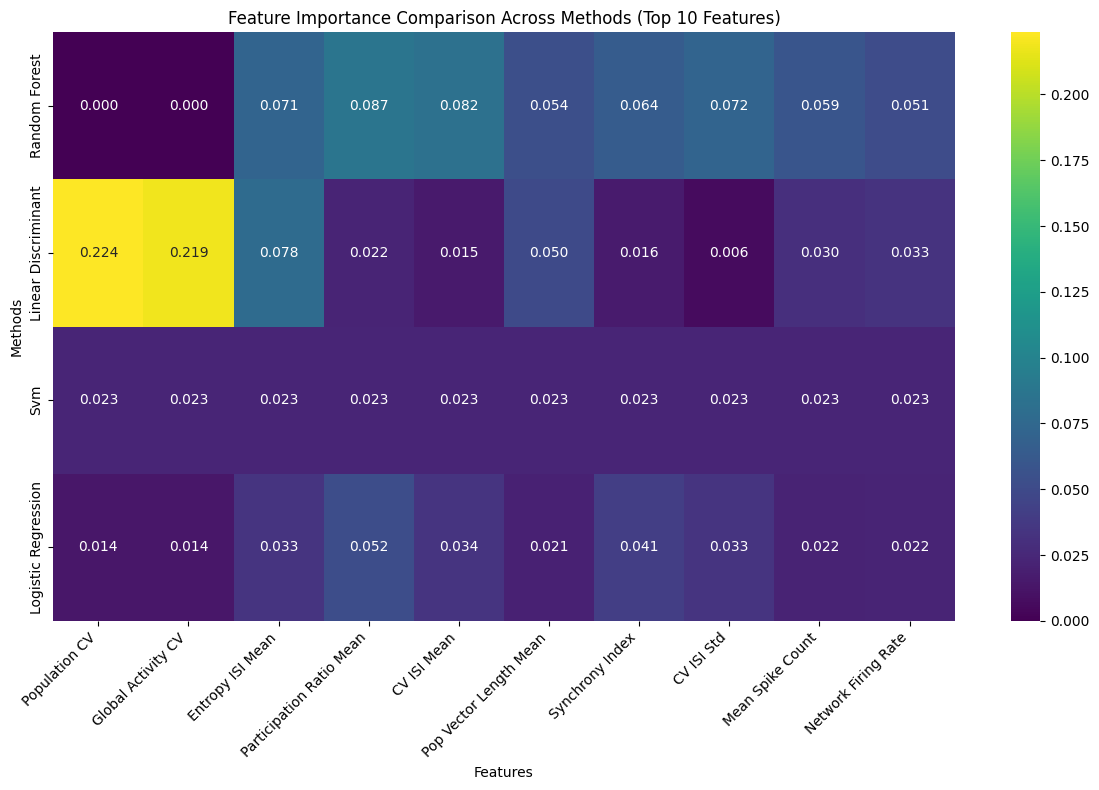

In [5]:
# Visualize method comparison
fig1 = plot_method_comparison(method_results, metric='cv_mean_accuracy')
fig1.show()

# Compare feature importance across methods
fig2 = plot_feature_importance_comparison(method_results, top_n=10)
fig2.show()

# Get best performing method
best_method = max(method_results.items(), 
                 key=lambda x: x[1].model_performance['cv_mean_accuracy'])
print(f"\nBest method: {best_method[0]} with {best_method[1].model_performance['cv_mean_accuracy']:.3f} accuracy")

### Using the best method (LDA)

For this dataset the method that was identified as most reliable was LDA. So, let's apply it separately.

/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/tmp/ipykernel_93976/4033074942.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


=== Linear Discriminant Analysis Results ===
Cross-validation accuracy: 1.000 ± 0.000
Training accuracy: 1.000

Top 10 Most Discriminative Features:
  31. population_cv            : 0.2236
  18. global_activity_cv       : 0.2186
  27. entropy_isi_mean         : 0.0777
  14. pop_vector_length_mean   : 0.0498
  42. chi_square_distance      : 0.0395
   6. total_spike_count        : 0.0330
  12. network_firing_rate      : 0.0330
   1. mean_firing_rate         : 0.0299
   7. mean_spike_count         : 0.0299
  43. population_spike_synchrony: 0.0243

Classification Report:
                       precision    recall  f1-score   support

       chronic-stress       1.00      1.00      1.00        60
              control       1.00      1.00      1.00        60
miR-186-5p-inhibition       1.00      1.00      1.00        60

             accuracy                           1.00       180
            macro avg       1.00      1.00      1.00       180
         weighted avg       1.00      1.00    

/tmp/ipykernel_93976/4033074942.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


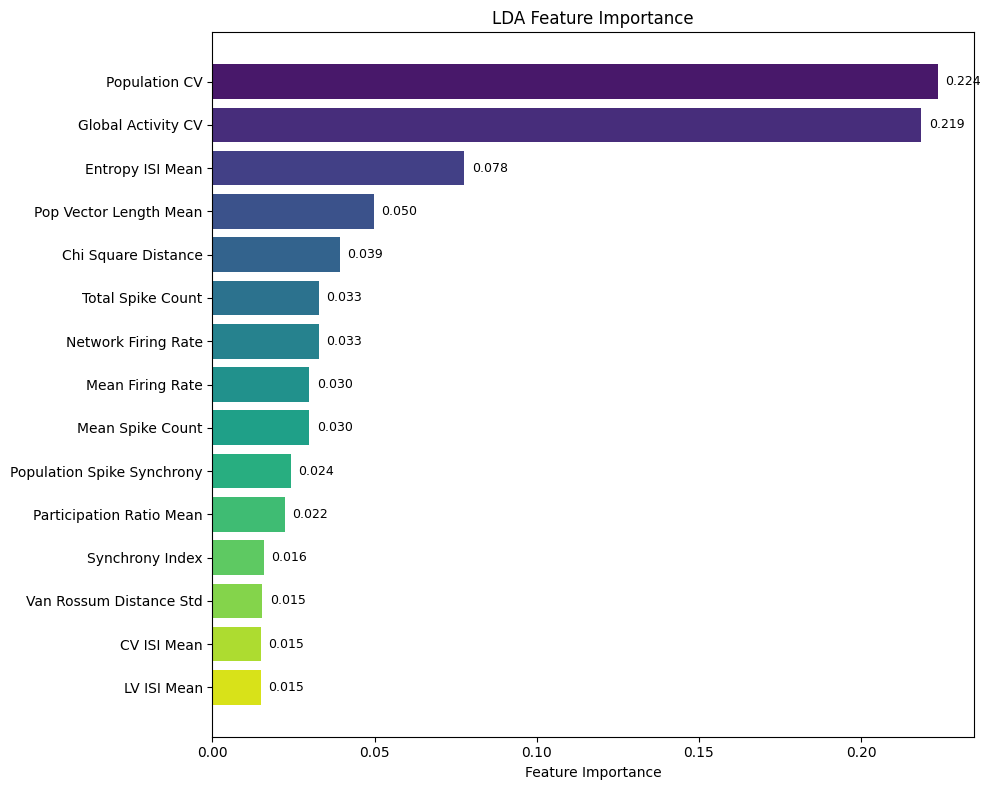

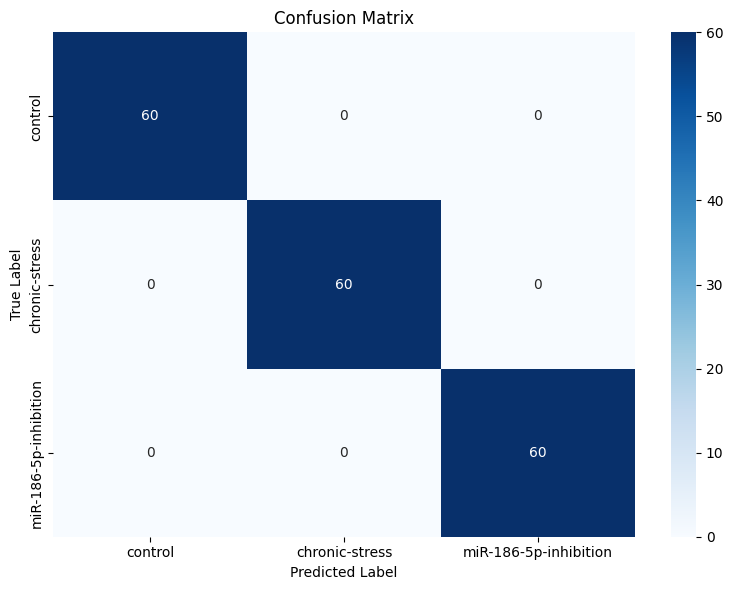

In [6]:
from mea_flow.analysis import identify_discriminative_features, DiscriminantConfig
from mea_flow.visualization import plot_feature_importance, plot_confusion_matrix

# Configure the best method (Linear Discriminant Analysis)
config = DiscriminantConfig(
    method="LDA",  # Best performing method
    target_column="condition",
    exclude_columns=list(data.columns)[-6:],
    scale_features=True,
    cross_validation=True,
    cv_folds=5
)
# Run discriminant analysis
results = identify_discriminative_features(data, config)

# Print performance metrics
print("=== Linear Discriminant Analysis Results ===")
print(f"Cross-validation accuracy: {results.model_performance['cv_mean_accuracy']:.3f} ± {results.model_performance['cv_std_accuracy']:.3f}")
print(f"Training accuracy: {results.model_performance['train_accuracy']:.3f}")

# Show top discriminative features
print(f"\nTop 10 Most Discriminative Features:")
for i, row in results.feature_importance.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# Visualize feature importance
fig1 = plot_feature_importance(results, top_n=15, title="LDA Feature Importance")
fig1.show()

# Show confusion matrix
conditions = ['control', 'chronic-stress', 'miR-186-5p-inhibition']
fig2 = plot_confusion_matrix(results, class_names=conditions, figsize=(8, 6))
fig2.show()

# Print classification report
print(f"\nClassification Report:")
print(results.classification_report)

# Access the trained model for further analysis
trained_model = results.model
print(f"\nModel type: {type(trained_model).__name__}")
print(f"Number of components: {trained_model.n_components}")

## Conclusion

For this dataset, the irregularity of spiking activity (as measured by the CV-ISI) is the most discriminative feature, indicating that modulating firing profile is the most significant effect of the experimental manipulation. Using this conclusion, we can plot a focused comparison.

Plot saved to: most_discriminative_features.png


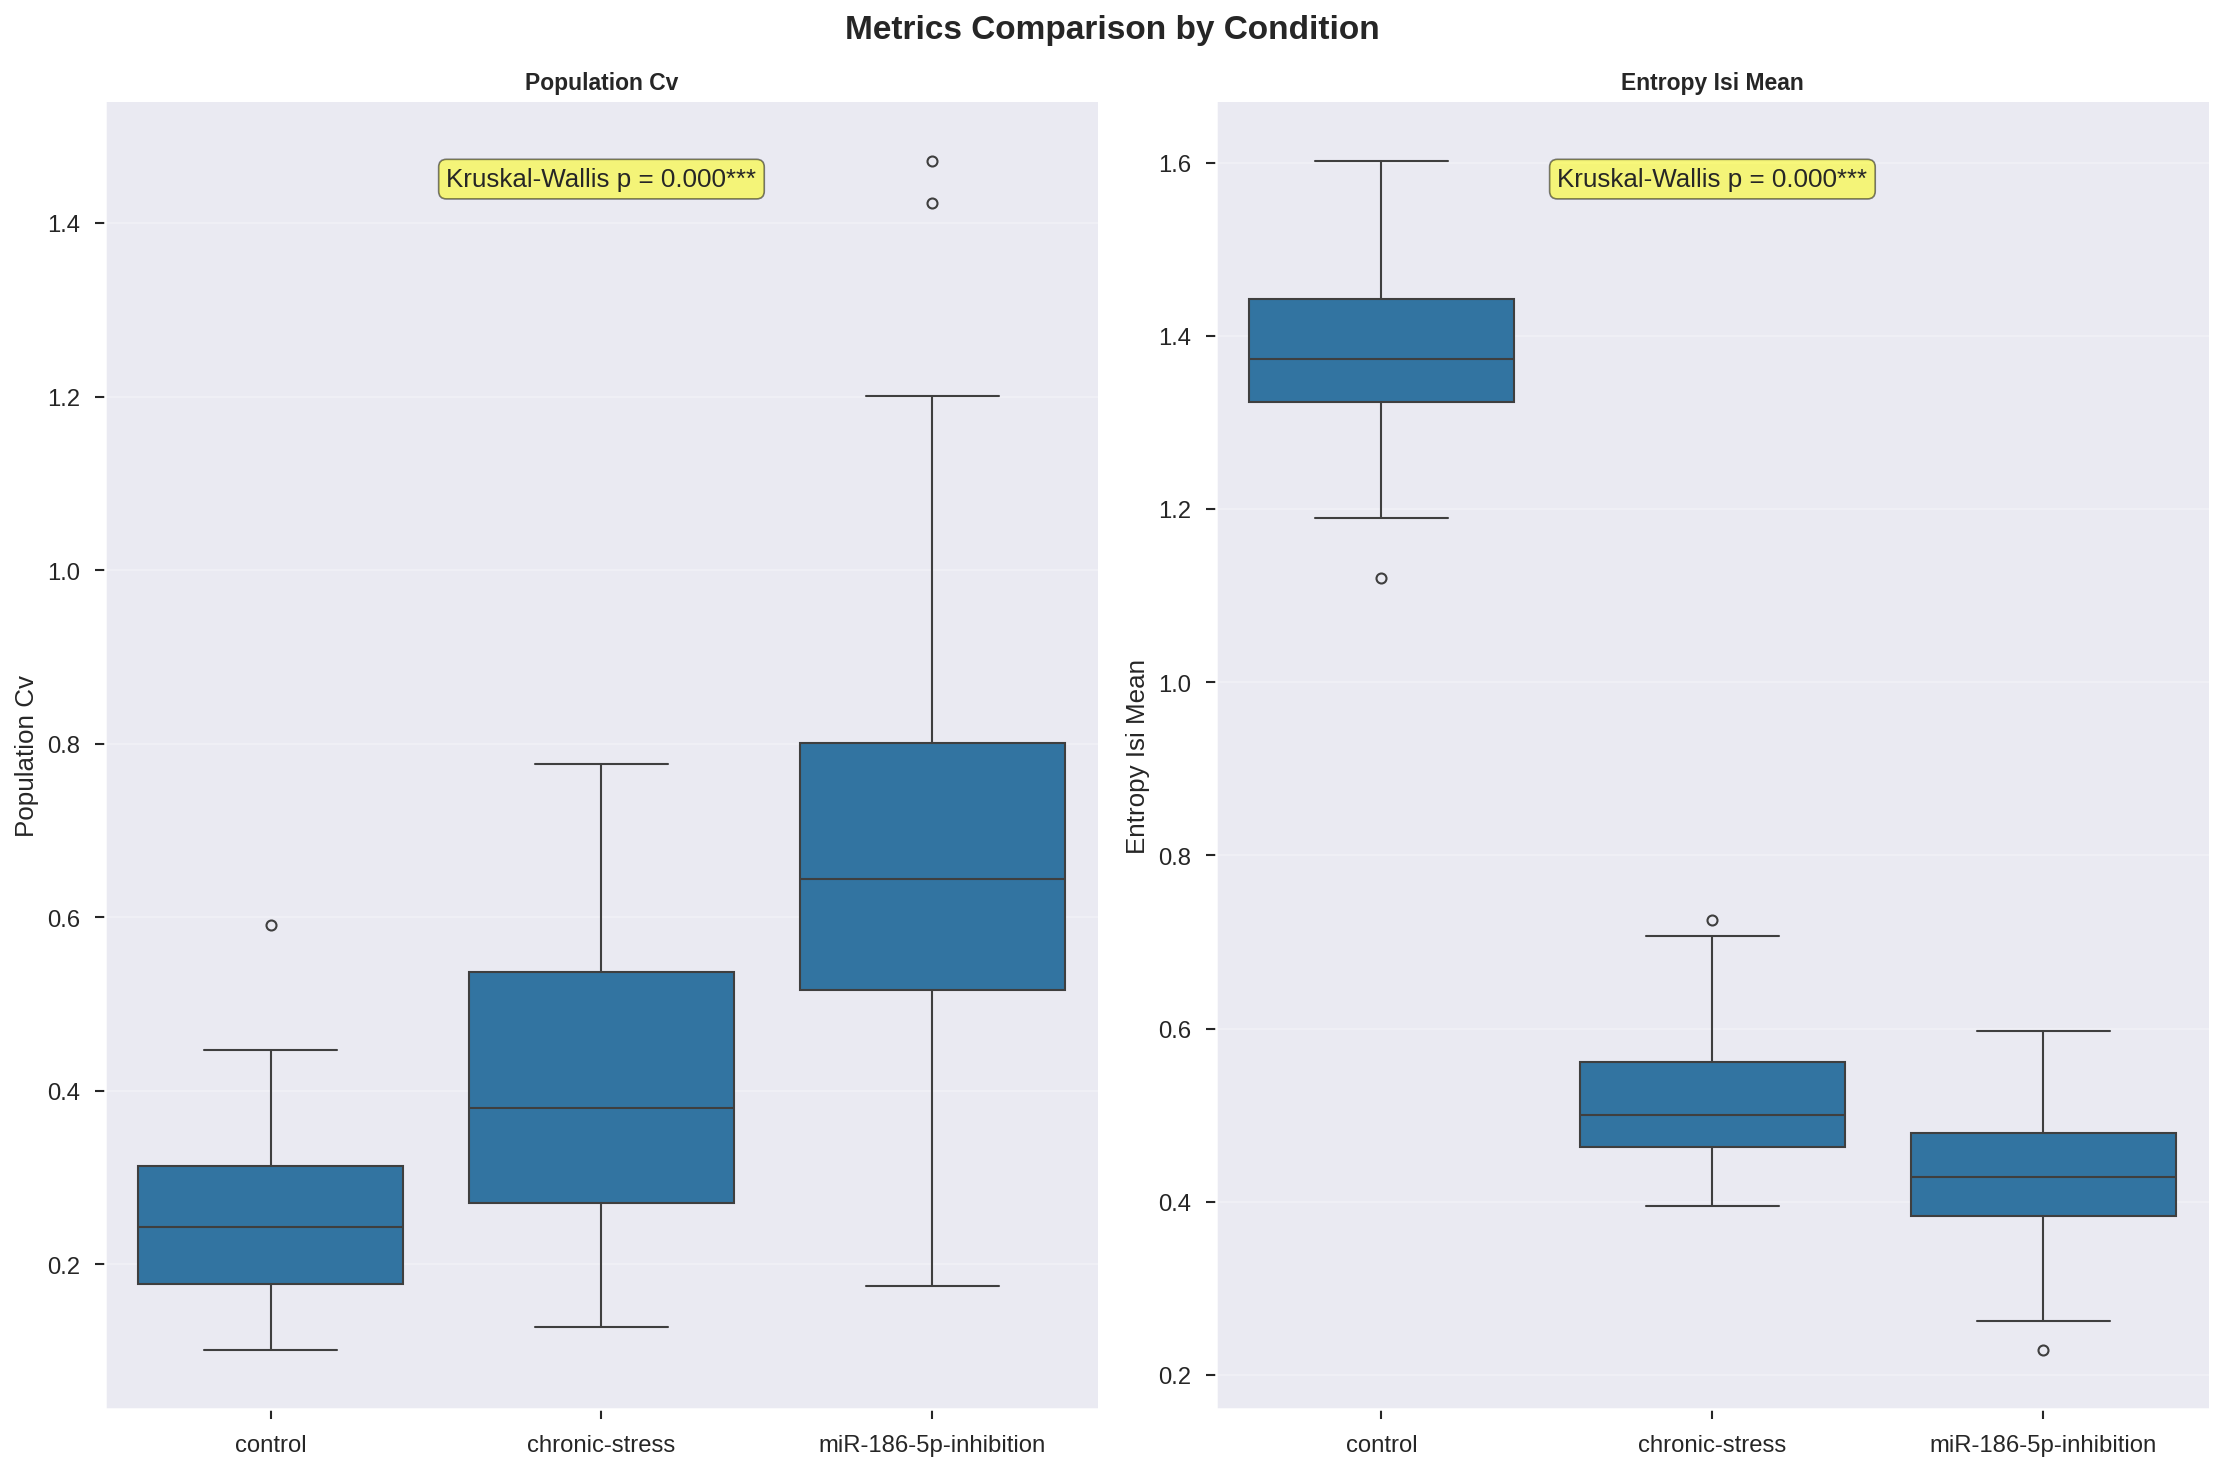

In [7]:
from mea_flow.visualization import MEAPlotter
plotter = MEAPlotter()

# Activity comparison across conditions
plotter.plot_metrics_comparison(
    results_temporal, 
    metrics=['population_cv', 'entropy_isi_mean'],
    group_by='condition',
    save_path='most_discriminative_features.png'
)

---

### Let's look at a less sample-rich dataset

In [8]:
results_global

,Unnamed: 0,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,...,network_burst_spikes_mean,network_burst_spikes_std,network_burst_peak_activity_mean,network_burst_peak_activity_std,inter_network_burst_interval_mean,inter_network_burst_interval_std,group_type,group_id,n_channels,recording_length
0,0,control,92.690914,26.808077,91.244596,160.407216,44.760928,1957618,30587.781250,8846.601592,...,3790.100719,3417.634163,151.381295,24.971464,2.162899,2.238878,global,all,64,329.997624
1,1,chronic-stress,38.418214,10.569137,38.153580,62.455445,18.548752,811381,12677.828125,3487.764912,...,1247.915556,1024.560080,95.160000,23.633520,1.327723,1.112842,global,all,64,329.995248
2,2,miR-186-5p-inhibition,10.042631,3.238903,9.654927,18.706799,4.421387,212092,3313.937500,1068.795860,...,553.257576,359.466010,53.840909,14.377397,2.259847,2.659705,global,all,64,329.986976


In [9]:
# Create base configuration
base_config = DiscriminantConfig(
    target_column="condition",
    exclude_columns=list(results_global.columns)[-4:],  # Non-feature columns
    scale_features=True,
    cross_validation=True,
    cv_folds=5
)

# Compare all methods
method_results = compare_discriminant_methods(
    data=results_global,
    base_config=base_config,
    methods=None  # Uses all available methods
)

# View results
for method_name, result in method_results.items():
    print(f"\n{method_name.upper()}:")
    print(f"  CV Accuracy: {result.model_performance['cv_mean_accuracy']:.3f} ± {result.model_performance['cv_std_accuracy']:.3f}")
    print(f"  Train Accuracy: {result.model_performance['train_accuracy']:.3f}")
    print(f"  Top 3 Features:")
    for i, row in result.feature_importance.head(3).iterrows():
        print(f"    {row['feature']}: {row['importance']:.3f}")


RANDOM_FOREST:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    lv_isi_std: 0.047
    lv_isi_mean: 0.047
    network_firing_rate: 0.047

SVM:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    Unnamed: 0: 0.014
    mean_firing_rate: 0.014
    std_firing_rate: 0.014

LOGISTIC_REGRESSION:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    pearson_cc_max: 0.023
    network_burst_rate: 0.023
    network_burst_count: 0.023


/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:210: UserWarning: Reducing CV folds from 5 to 2 due to small dataset size
  warnings.warn(f"Reducing CV folds from {config.cv_folds} t

/tmp/ipykernel_93976/3342975506.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()



Best method: random_forest with nan accuracy


/tmp/ipykernel_93976/3342975506.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


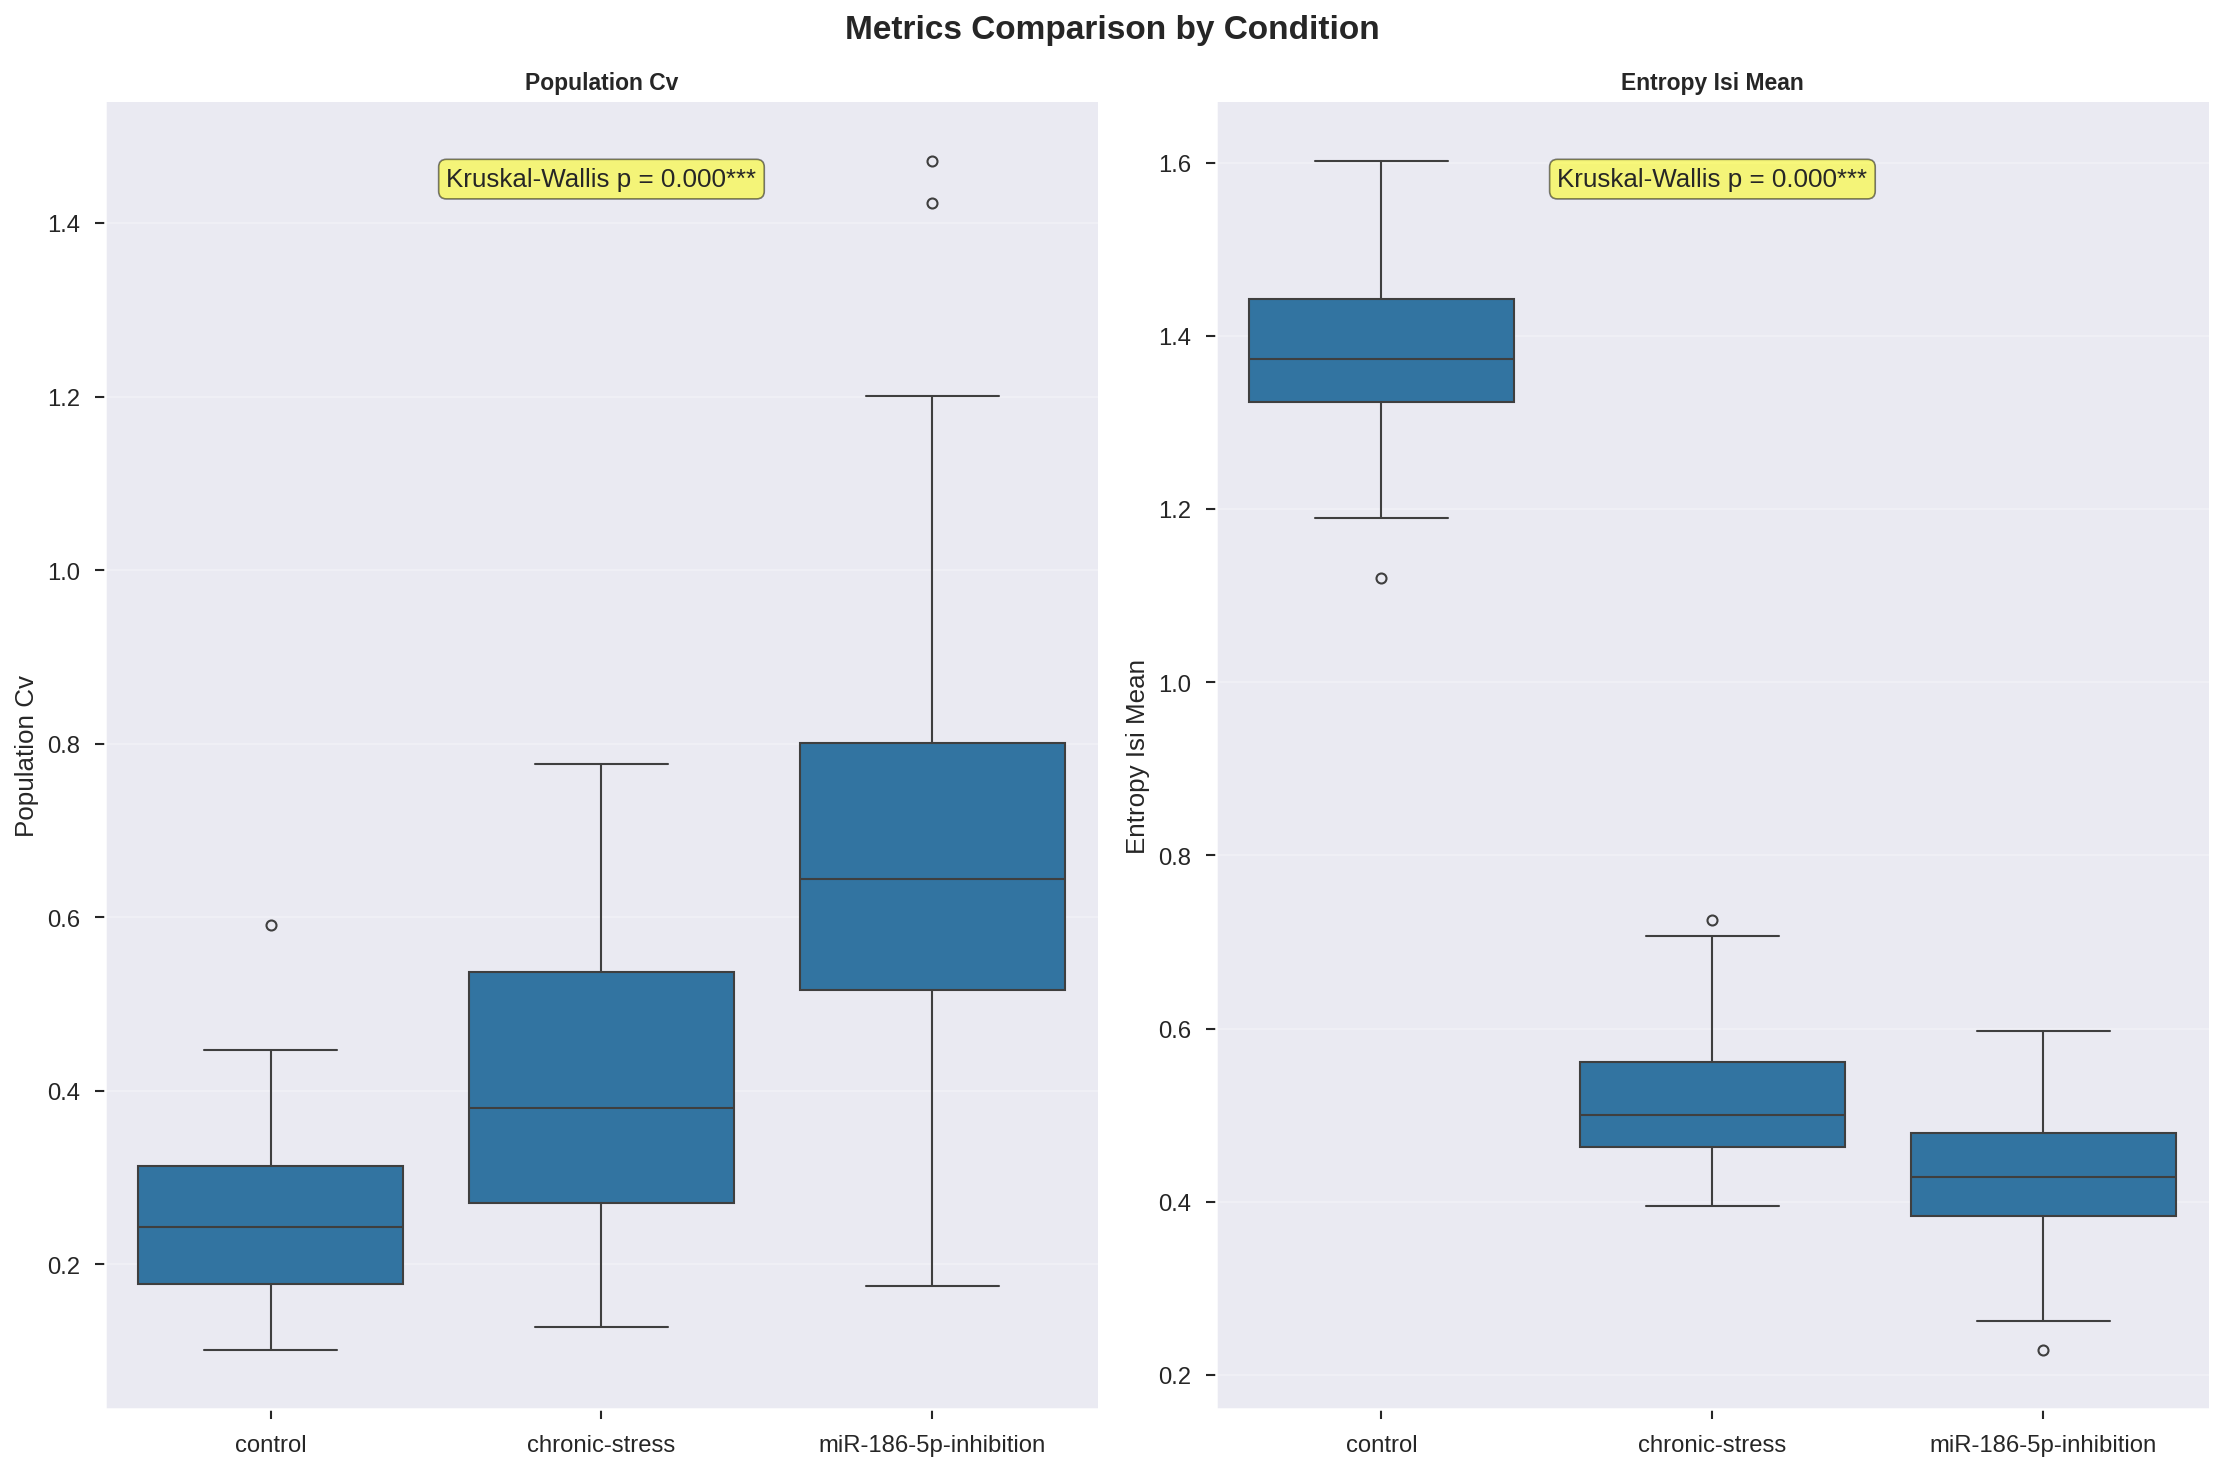

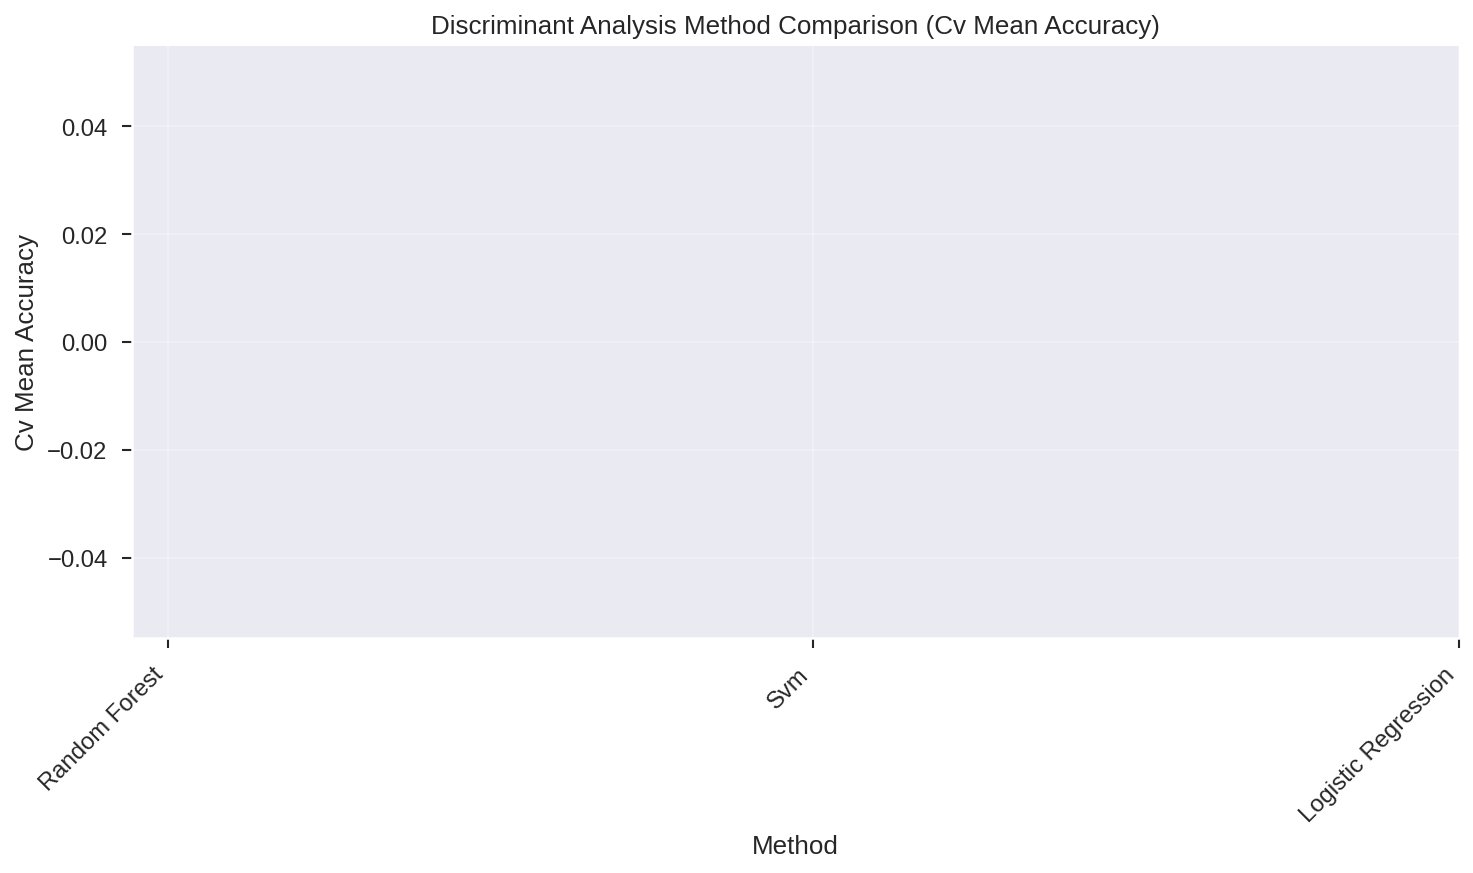

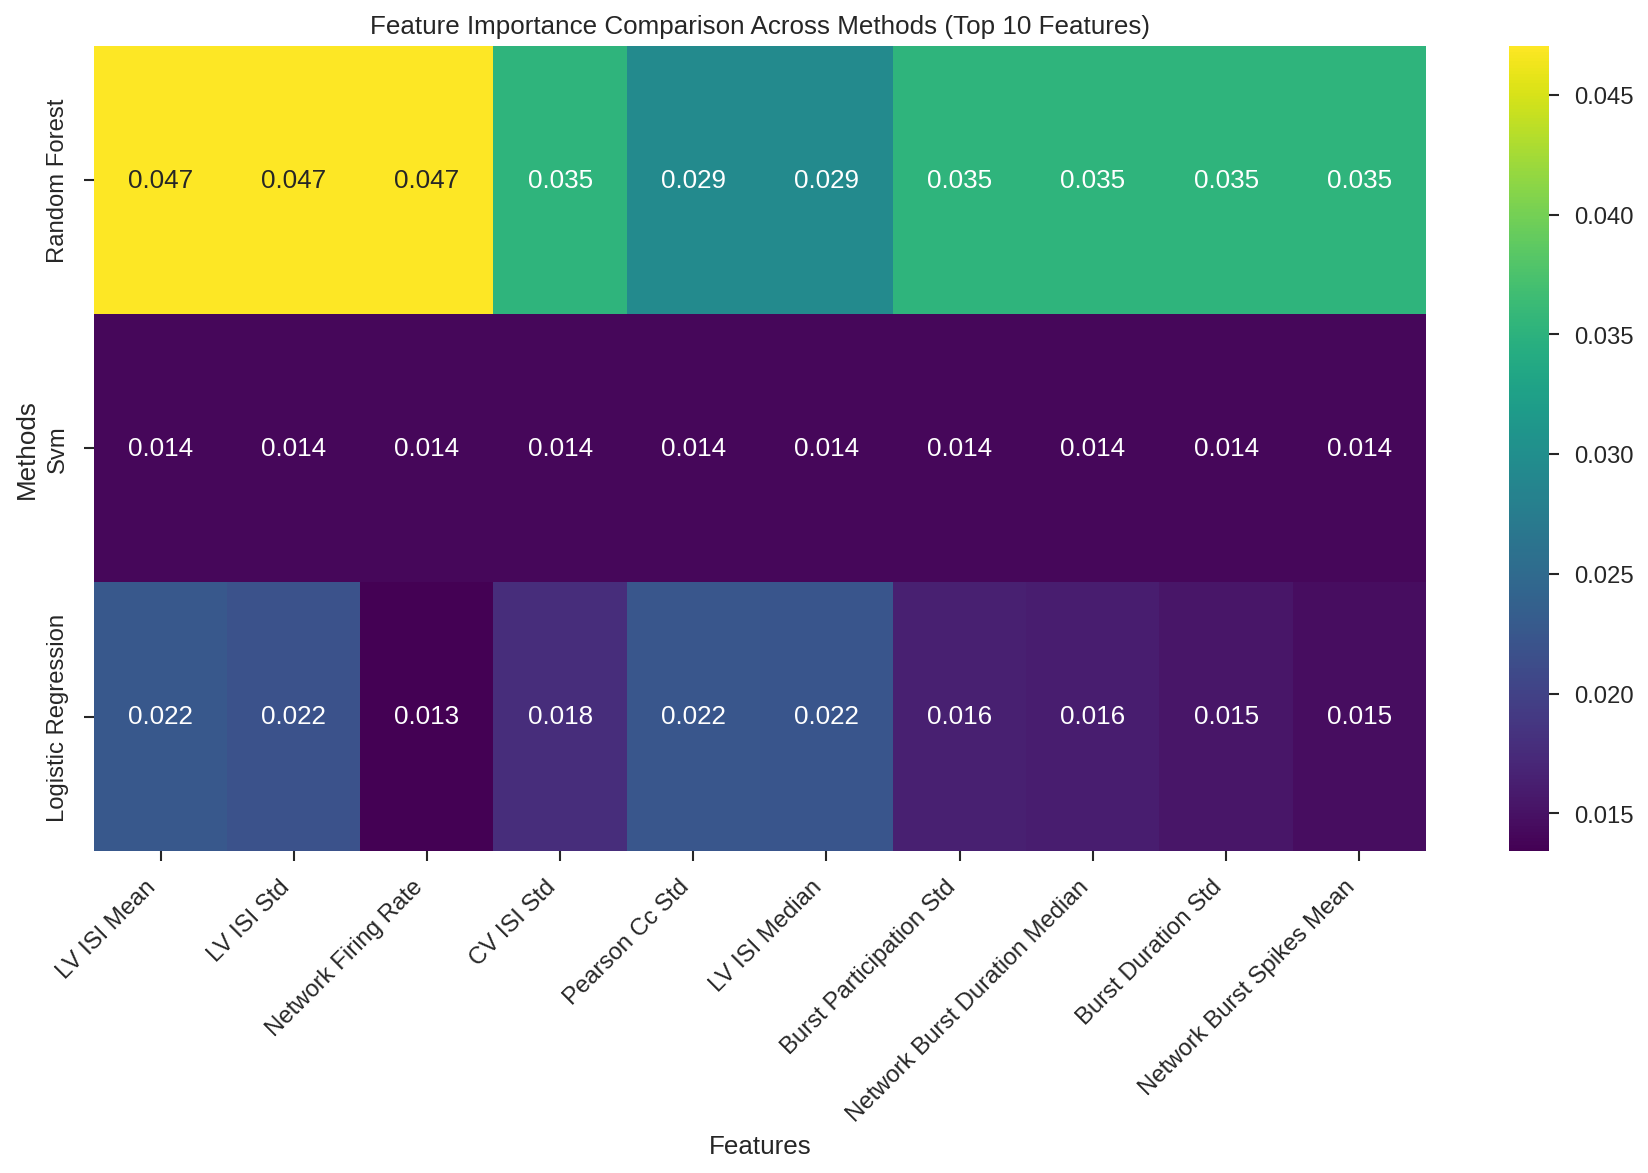

In [10]:
# Visualize method comparison
fig1 = plot_method_comparison(method_results, metric='cv_mean_accuracy')
fig1.show()

# Compare feature importance across methods
fig2 = plot_feature_importance_comparison(method_results, top_n=10)
fig2.show()

# Get best performing method
best_method = max(method_results.items(), 
                 key=lambda x: x[1].model_performance['cv_mean_accuracy'])
print(f"\nBest method: {best_method[0]} with {best_method[1].model_performance['cv_mean_accuracy']:.3f} accuracy")

In [11]:
results_wells

,Unnamed: 0,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,...,network_burst_spikes_mean,network_burst_spikes_std,network_burst_peak_activity_mean,network_burst_peak_activity_std,inter_network_burst_interval_mean,inter_network_burst_interval_std,group_type,group_id,n_channels,recording_length
0,0,control,104.466472,29.450876,112.193232,160.407216,44.760928,551579,34473.6875,9718.719255,...,2114.163793,1166.851651,74.844828,18.861840,2.578870,2.183213,well,1,16,329.997624
1,1,control,92.306346,18.012014,92.023390,122.300881,54.867062,487374,30460.8750,5943.921842,...,1787.693548,1243.703044,68.056452,15.311445,2.391220,2.718266,well,2,16,329.997624
2,2,control,99.640490,29.016119,94.946138,140.613134,55.257974,526098,32881.1250,9575.250172,...,1724.700000,1345.219375,70.078571,18.680038,2.148129,2.850874,well,3,16,329.997624
3,3,control,74.350346,17.818117,78.285412,116.334171,45.306387,392567,24535.4375,5879.936160,...,1967.100000,1080.491985,67.780000,14.234170,2.938081,3.494623,well,4,16,329.997624
4,4,chronic-stress,40.369331,8.119638,39.405113,62.243321,21.445763,213147,13321.6875,2679.441820,...,946.281046,594.239322,60.065359,12.176090,1.954211,1.367024,well,1,16,329.995248
5,5,chronic-stress,29.549289,6.964447,28.570108,45.352168,19.512402,156018,9751.1250,2298.234319,...,795.858108,373.334826,54.418919,11.784101,2.024694,2.091276,well,2,16,329.995248
6,6,chronic-stress,45.367699,9.953745,41.999090,62.455445,30.985295,239538,14971.1250,3284.688605,...,858.097826,566.042796,56.233696,13.972207,1.588142,1.857207,well,3,16,329.995248
7,7,chronic-stress,38.386538,10.127019,39.806634,56.670513,18.548752,202678,12667.3750,3341.868001,...,908.697183,577.887642,59.612676,12.314453,2.049291,1.359245,well,4,16,329.995248
8,8,miR-186-5p-inhibition,9.064941,2.627480,8.788226,16.182457,5.551734,47861,2991.3125,867.034149,...,479.178082,218.815951,43.958904,9.832067,4.061806,2.963938,well,1,16,329.986976
9,9,miR-186-5p-inhibition,9.978424,3.197600,9.157937,15.164235,5.248692,52684,3292.7500,1055.166190,...,422.988764,182.098781,36.696629,9.418371,3.162273,5.327819,well,2,16,329.986976


In [12]:
# Create base configuration
base_config = DiscriminantConfig(
    target_column="condition",
    exclude_columns=list(results_wells.columns)[-4:],  # Non-feature columns
    scale_features=True,
    cross_validation=True,
    cv_folds=5
)

# Compare all methods
method_results = compare_discriminant_methods(
    data=results_wells,
    base_config=base_config,
    methods=None  # Uses all available methods
)

# View results
for method_name, result in method_results.items():
    print(f"\n{method_name.upper()}:")
    print(f"  CV Accuracy: {result.model_performance['cv_mean_accuracy']:.3f} ± {result.model_performance['cv_std_accuracy']:.3f}")
    print(f"  Train Accuracy: {result.model_performance['train_accuracy']:.3f}")
    print(f"  Top 3 Features:")
    for i, row in result.feature_importance.head(3).iterrows():
        print(f"    {row['feature']}: {row['importance']:.3f}")

/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:210: UserWarning: Reducing CV folds from 5 to 4 due to small dataset size
  warnings.warn(f"Reducing CV folds from {config.cv_folds} t


RANDOM_FOREST:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    lvr_isi_mean: 0.041
    network_burst_count: 0.037
    inter_network_burst_interval_mean: 0.035

LINEAR_DISCRIMINANT:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    network_burst_spikes_mean: 0.102
    fano_factor_mean: 0.071
    synchrony_index: 0.059

SVM:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    Unnamed: 0: 0.014
    mean_firing_rate: 0.014
    std_firing_rate: 0.014

LOGISTIC_REGRESSION:
  CV Accuracy: 1.000 ± 0.000
  Train Accuracy: 1.000
  Top 3 Features:
    lv_isi_mean: 0.026
    lvr_isi_mean: 0.026
    lv_isi_median: 0.025


/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:210: UserWarning: Reducing CV folds from 5 to 4 due to small dataset size
  warnings.warn(f"Reducing CV folds from {config.cv_folds} t

/tmp/ipykernel_93976/3342975506.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()



Best method: random_forest with 1.000 accuracy


/tmp/ipykernel_93976/3342975506.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


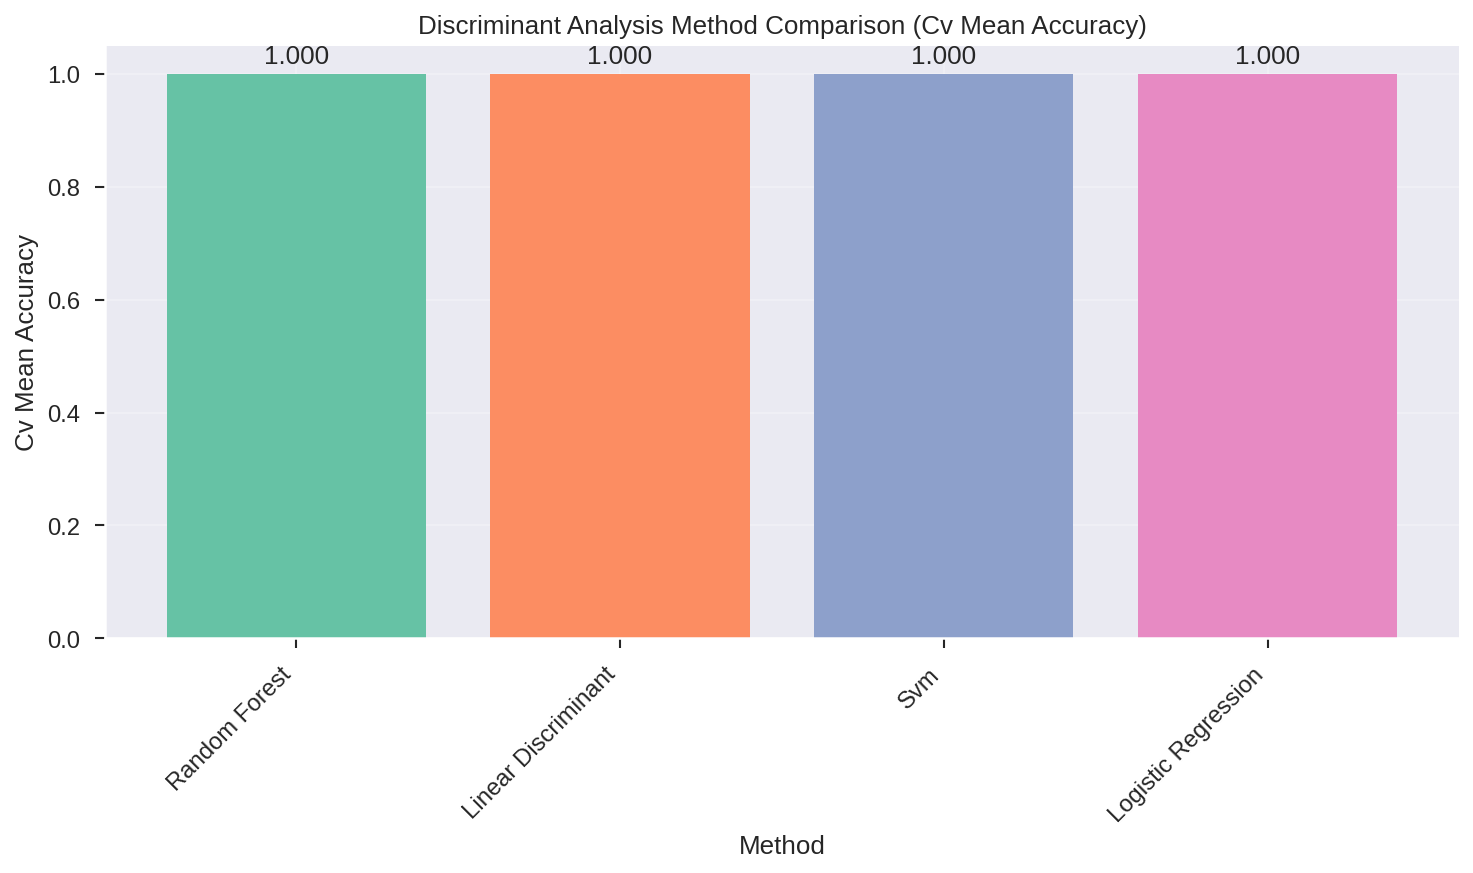

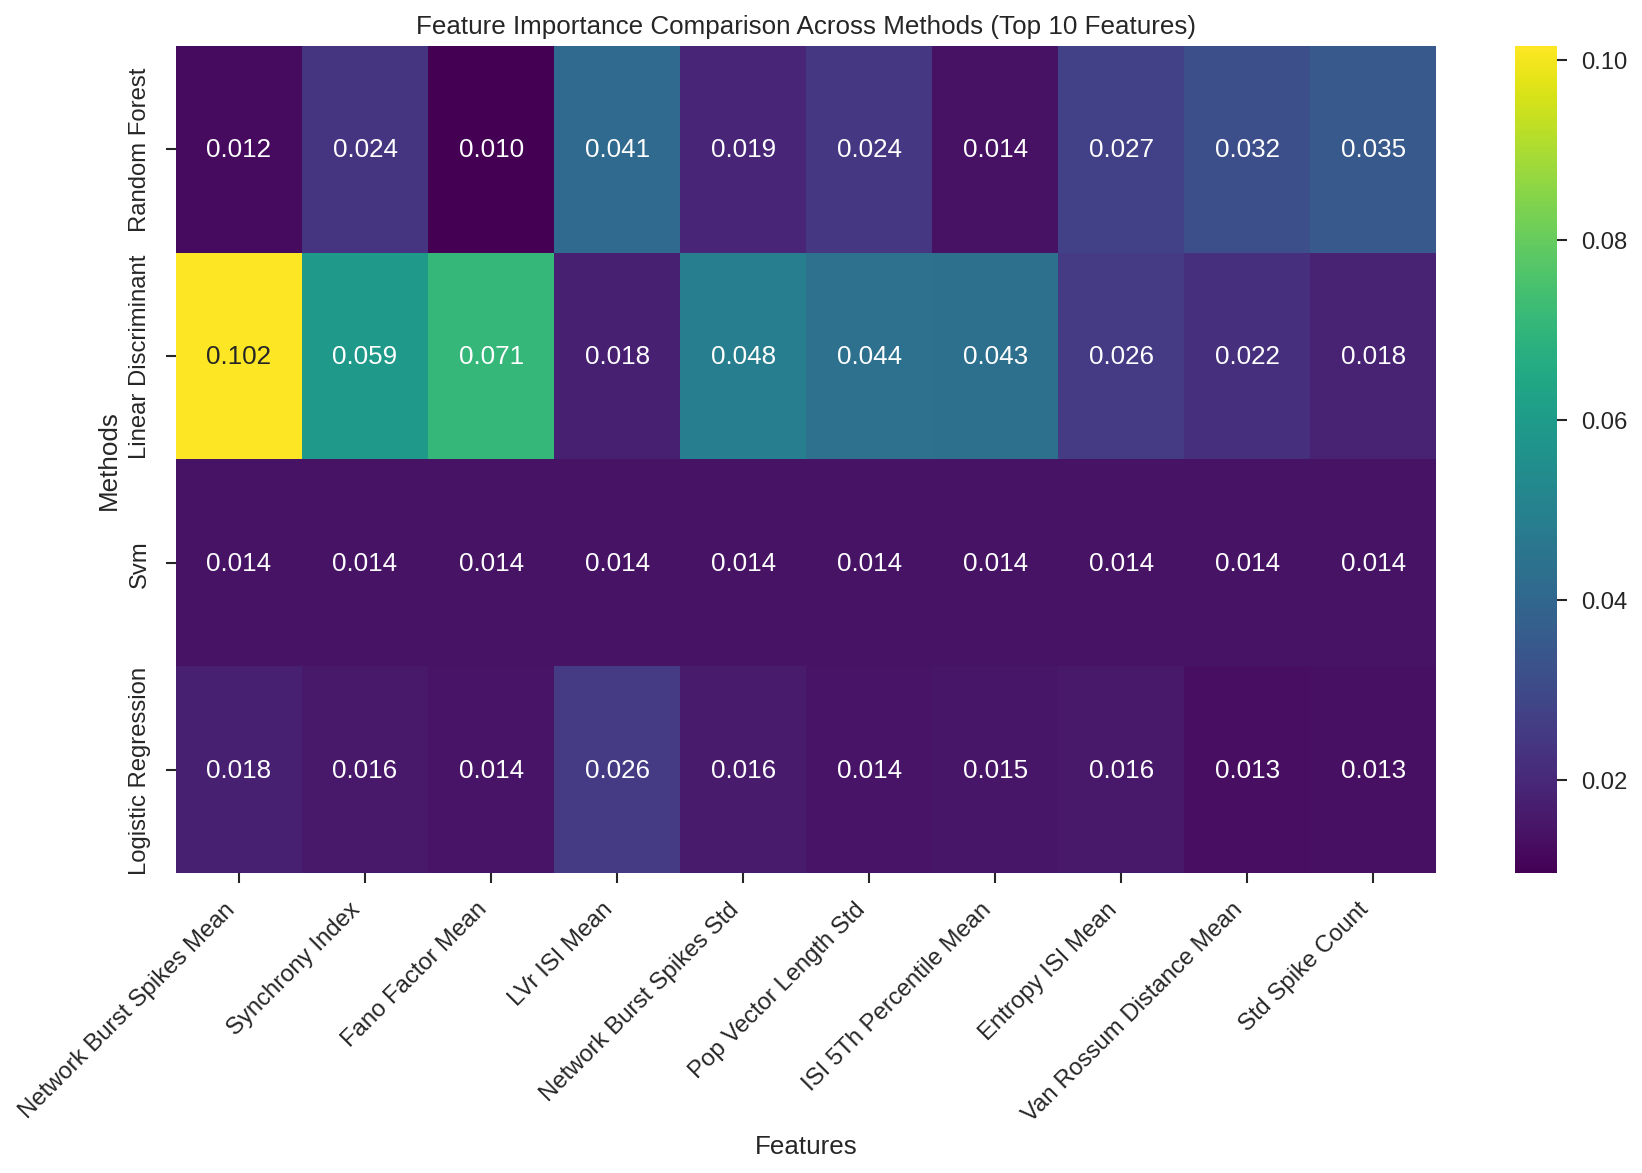

In [ ]:
# Visualize method comparison
fig1 = plot_method_comparison(method_results, metric='cv_mean_accuracy')

# Compare feature importance across methods
fig2 = plot_feature_importance_comparison(method_results, top_n=10)

# Get best performing method
best_method = max(method_results.items(), 
                 key=lambda x: x[1].model_performance['cv_mean_accuracy'])
print(f"\nBest method: {best_method[0]} with {best_method[1].model_performance['cv_mean_accuracy']:.3f} accuracy")

--- 

And let's complete with the most comprehensive dataset, where each channel is independently analysed

In [14]:
results_channels

,Unnamed: 0,condition,mean_firing_rate,std_firing_rate,median_firing_rate,max_firing_rate,min_firing_rate,total_spike_count,mean_spike_count,std_spike_count,...,pearson_cc_std,isi_distance,spike_distance,spike_sync_distance,group_type,group_id,channel_id,n_channels,recording_length,well_id
0,0,control,44.760928,0.0,44.760928,44.760928,44.760928,14771,14771.0,0.0,...,NaN,NaN,NaN,NaN,channel,0,0,1,329.997624,1
1,1,control,119.955409,0.0,119.955409,119.955409,119.955409,39585,39585.0,0.0,...,NaN,NaN,NaN,NaN,channel,1,1,1,329.997624,1
2,2,control,97.152215,0.0,97.152215,97.152215,97.152215,32060,32060.0,0.0,...,NaN,NaN,NaN,NaN,channel,2,2,1,329.997624,1
3,3,control,59.973159,0.0,59.973159,59.973159,59.973159,19791,19791.0,0.0,...,NaN,NaN,NaN,NaN,channel,3,3,1,329.997624,1
4,4,control,160.407216,0.0,160.407216,160.407216,160.407216,52934,52934.0,0.0,...,NaN,NaN,NaN,NaN,channel,4,4,1,329.997624,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,187,miR-186-5p-inhibition,9.594318,0.0,9.594318,9.594318,9.594318,3166,3166.0,0.0,...,NaN,NaN,NaN,NaN,channel,59,59,1,329.986976,4
188,188,miR-186-5p-inhibition,15.573342,0.0,15.573342,15.573342,15.573342,5139,5139.0,0.0,...,NaN,NaN,NaN,NaN,channel,60,60,1,329.986976,4
189,189,miR-186-5p-inhibition,4.421387,0.0,4.421387,4.421387,4.421387,1459,1459.0,0.0,...,NaN,NaN,NaN,NaN,channel,61,61,1,329.986976,4
190,190,miR-186-5p-inhibition,14.073283,0.0,14.073283,14.073283,14.073283,4644,4644.0,0.0,...,NaN,NaN,NaN,NaN,channel,62,62,1,329.986976,4


In [15]:
# Create base configuration
base_config = DiscriminantConfig(
    target_column="condition",
    exclude_columns=list(results_global.columns)[-6:],  # Non-feature columns
    scale_features=True,
    cross_validation=True,
    cv_folds=5
)

# Compare all methods
method_results = compare_discriminant_methods(
    data=results_global,
    base_config=base_config,
    methods=None  # Uses all available methods
)

# View results
for method_name, result in method_results.items():
    print(f"\n{method_name.upper()}:")
    print(f"  CV Accuracy: {result.model_performance['cv_mean_accuracy']:.3f} ± {result.model_performance['cv_std_accuracy']:.3f}")
    print(f"  Train Accuracy: {result.model_performance['train_accuracy']:.3f}")
    print(f"  Top 3 Features:")
    for i, row in result.feature_importance.head(3).iterrows():
        print(f"    {row['feature']}: {row['importance']:.3f}")


RANDOM_FOREST:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    network_burst_count: 0.047
    chi_square_distance: 0.041
    population_cv: 0.035

SVM:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    Unnamed: 0: 0.014
    mean_firing_rate: 0.014
    std_firing_rate: 0.014

LOGISTIC_REGRESSION:
  CV Accuracy: nan ± nan
  Train Accuracy: 1.000
  Top 3 Features:
    pearson_cc_max: 0.025
    network_burst_rate: 0.025
    network_burst_count: 0.025


/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:274: UserWarning: NaN values found in features, using robust imputation
  warnings.warn("NaN values found in features, using robust imputation")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column isi_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:282: UserWarning: Column spike_sync_distance is entirely NaN, dropping it
  warnings.warn(f"Column {col} is entirely NaN, dropping it")
/home/neuro/repos/mea-flow/src/mea_flow/analysis/discriminant.py:210: UserWarning: Reducing CV folds from 5 to 2 due to small dataset size
  warnings.warn(f"Reducing CV folds from {config.cv_folds} t

/tmp/ipykernel_93976/3342975506.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()



Best method: random_forest with nan accuracy


/tmp/ipykernel_93976/3342975506.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


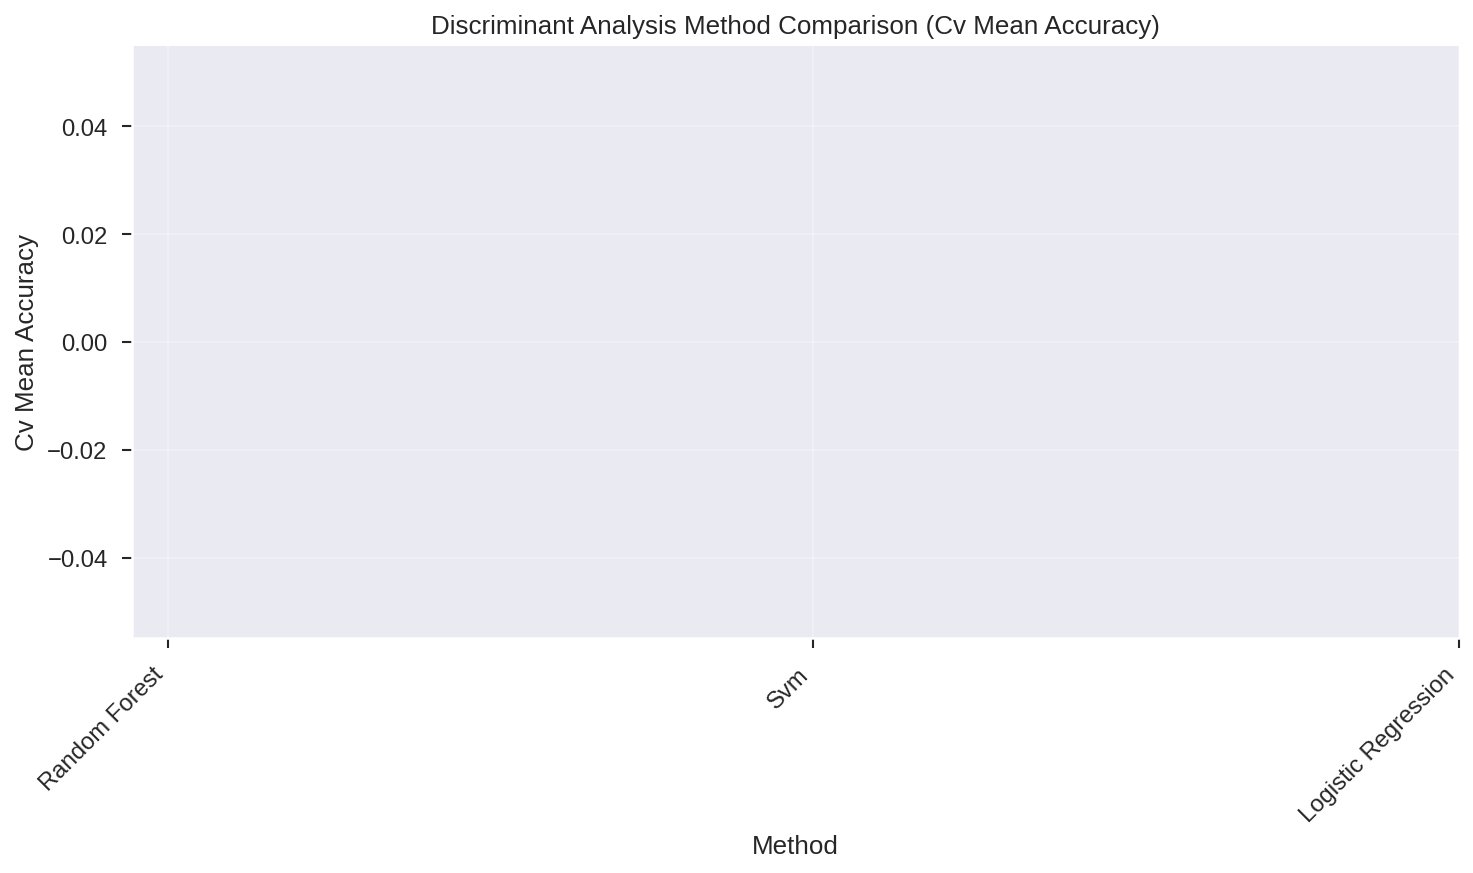

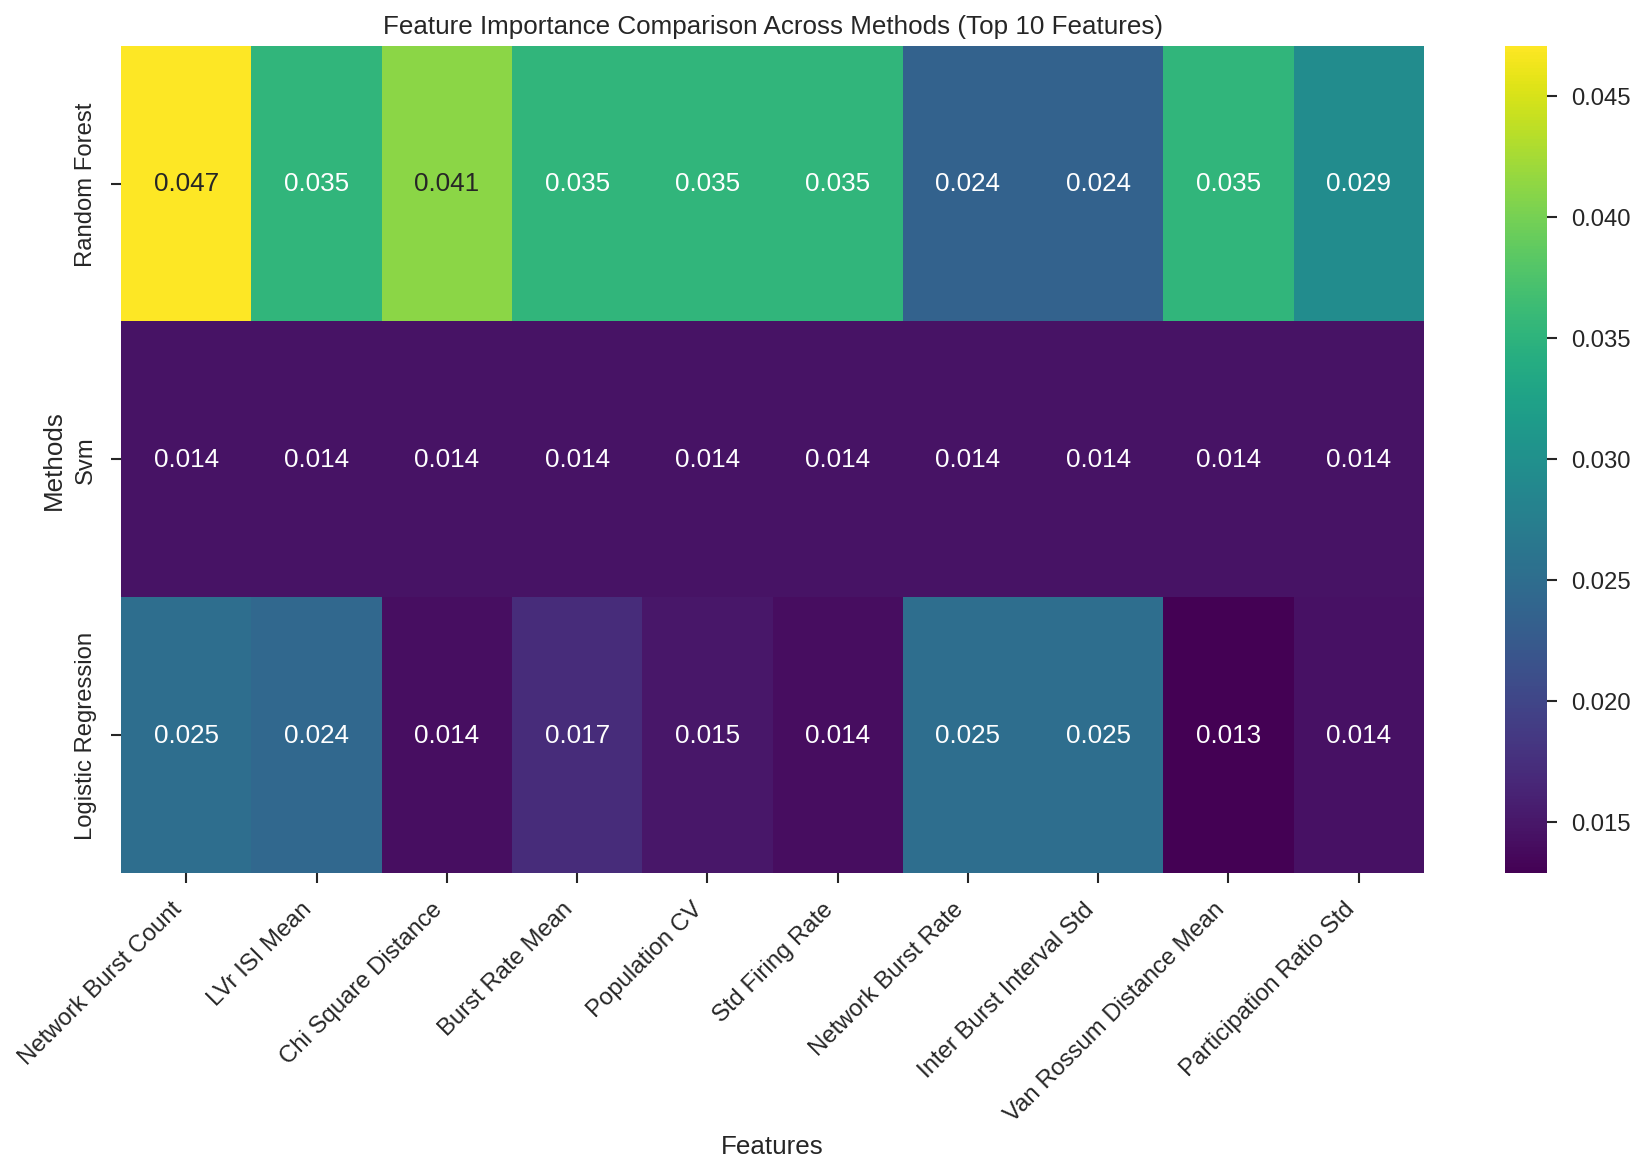

In [16]:
# Visualize method comparison
fig1 = plot_method_comparison(method_results, metric='cv_mean_accuracy')
fig1.show()

# Compare feature importance across methods
fig2 = plot_feature_importance_comparison(method_results, top_n=10)
fig2.show()

# Get best performing method
best_method = max(method_results.items(), 
                 key=lambda x: x[1].model_performance['cv_mean_accuracy'])
print(f"\nBest method: {best_method[0]} with {best_method[1].model_performance['cv_mean_accuracy']:.3f} accuracy")